# Pop vs Non-Pop Genre Classification
**by Kyle Furey & Dhruv Solanki**


## 1. Setup & Data Loading


In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfl
from tensorflow.keras import callbacks as tfkc



In [2]:
# Load behavioral Spotify dataset - CLEANED VERSION (No Data Leakage)
DATA_PATH = '../data/spotify_final_with_behavior.csv'

print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print('Total samples:', len(df))

# Define pop-vs-non-pop label using tags/genre (real Spotify metadata)
import re

pop_keyword_patterns = [
    r"\bpop\b",
    r"dance[- ]?pop",
    r"electro[- ]?pop",
    r"synth[- ]?pop",
    r"teen pop",
    r"pop rock",
    r"pop rap",
    r"latin pop",
    r"indie pop",
    r"k[- ]?pop",
    r"j[- ]?pop",
    r"c[- ]?pop",
]

def is_pop_track(row):
    # Genre column now contains the actual genres (was moved from tags column)
    text = f"{row.get('genre', '')}".lower()
    return int(any(re.search(pat, text) for pat in pop_keyword_patterns))

df['is_pop_genre'] = df.apply(is_pop_track, axis=1)
print('Pop class positive rate:', df['is_pop_genre'].mean())
print(f'Pop tracks: {df["is_pop_genre"].sum()}, Non-pop: {(df["is_pop_genre"] == 0).sum()}')

# ============================================================================
# FEATURE SELECTION - REMOVING DATA LEAKAGE
# ============================================================================
# CRITICAL: Remove features that are engineered to predict pop (data leakage)
# These features are too correlated with the target and give unrealistic results

# Base numeric features (safe - no leakage)
numeric_features = ['spotify_popularity', 'album_release_year', 'tempo_bpm_synth', 'position']
cat_feature = 'time_of_day_synth'
target_column = 'is_pop_genre'

# Extract additional safe features
df['is_explicit_binary'] = df['is_explicit'].astype(int)

# Extract temporal features from album_release_date
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')
df['release_month'] = df['album_release_date'].dt.month.fillna(0).astype(int)
df['release_decade'] = (df['album_release_year'] // 10 * 10).astype(int)

# Create interaction features (safe - no direct pop targeting)
df['popularity_x_year'] = df['spotify_popularity'] * df['album_release_year']
df['tempo_x_year'] = df['tempo_bpm_synth'] * df['album_release_year']

# Use ONLY safe derived features (removed leaky ones)
# REMOVED: tempo_is_pop_range (designed for pop 100-140 BPM - LEAKAGE!)
# REMOVED: mainstream_pop_signal (engineered to predict pop - LEAKAGE!)
# REMOVED: popular_recent (composite feature targeting pop - LEAKAGE!)
# REMOVED: has_pop_genre (directly from genre column - LEAKAGE!)
# REMOVED: genre_count (from genre column - potential LEAKAGE!)

safe_derived_features = []
if 'is_highly_popular' in df.columns:
    safe_derived_features.extend(['is_highly_popular', 'is_moderately_popular', 'popularity_normalized'])
if 'is_recent' in df.columns:
    safe_derived_features.extend(['is_recent', 'is_very_recent'])
# Only use tempo_normalized (not tempo_is_pop_range which targets pop specifically)
if 'tempo_normalized' in df.columns:
    safe_derived_features.append('tempo_normalized')
if 'is_daytime' in df.columns:
    safe_derived_features.append('is_daytime')
if 'is_not_explicit' in df.columns:
    safe_derived_features.append('is_not_explicit')

print(f'\n✅ Using {len(safe_derived_features)} SAFE derived features (leaky features removed)')
print(f'Safe features: {safe_derived_features}')

# Check for audio features (danceability, energy, valence, acousticness) - these are REAL features
audio_features = []
for feat in ['danceability', 'energy', 'valence', 'acousticness']:
    if feat in df.columns:
        audio_features.append(feat)

if audio_features:
    print(f'✅ Found {len(audio_features)} audio features: {audio_features}')
    numeric_features.extend(audio_features)

# Prepare feature sets - ONLY safe features
X_num = df[numeric_features + ['is_explicit_binary', 'release_month', 'release_decade', 
                                'popularity_x_year', 'tempo_x_year'] + safe_derived_features].copy()
X_cat = df[[cat_feature]].copy()
y = df[target_column].astype(int).values

# One-hot encode time_of_day_synth
X_cat_dummies = pd.get_dummies(X_cat, columns=[cat_feature], drop_first=False)

# ============================================================================
# SAFE GENRE/TAGS FEATURES (No Data Leakage)
# ============================================================================
# Use genre/tags but REMOVE the exact "pop" keywords used to create target
# This gives us genre information without direct leakage

if 'genre' in df.columns:
    print('\n📝 Extracting SAFE genre features (removing pop keywords to prevent leakage)...')
    
    # Remove the exact pop keywords we use for target creation
    pop_keywords_to_remove = ['pop', 'dance pop', 'electro pop', 'synth pop', 
                              'teen pop', 'pop rock', 'pop rap', 'latin pop', 
                              'indie pop', 'k-pop', 'j-pop', 'c-pop', 'k pop', 'j pop', 'c pop']
    
    # Create cleaned genre text (remove pop keywords)
    def clean_genre_text(text):
        if pd.isna(text):
            return ''
        text_lower = str(text).lower()
        for keyword in pop_keywords_to_remove:
            text_lower = text_lower.replace(keyword, '')
        return text_lower.strip()
    
    genre_cleaned = df['genre'].apply(clean_genre_text)
    
    # Use TF-IDF on cleaned genre (only non-pop genre information)
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Only use genres that appear in at least 20 tracks (to avoid noise)
    tfidf_genre = TfidfVectorizer(
        max_features=20,  # Top 20 genre terms
        ngram_range=(1, 2),  # Single words and 2-word phrases
        min_df=20,  # Must appear in at least 20 tracks
        stop_words='english'
    )
    
    try:
        X_genre_tfidf = tfidf_genre.fit_transform(genre_cleaned).astype('float32')
        genre_feature_names = [f'genre_{name}' for name in tfidf_genre.get_feature_names_out()]
        print(f'✅ Created {X_genre_tfidf.shape[1]} safe genre TF-IDF features')
        print(f'   Genre terms: {tfidf_genre.get_feature_names_out()[:10]}...')
        
        # Convert to dense for concatenation
        import scipy.sparse as sp
        if sp.issparse(X_genre_tfidf):
            X_genre_tfidf = X_genre_tfidf.toarray()
    except Exception as e:
        print(f'⚠️  Could not create genre features: {e}')
        X_genre_tfidf = np.zeros((len(df), 0), dtype='float32')
        genre_feature_names = []
else:
    print('\n⚠️  No genre column found - using metadata only')
    X_genre_tfidf = np.zeros((len(df), 0), dtype='float32')
    genre_feature_names = []

# Scale numeric features on the full dataset
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Build final feature matrix: numeric + one-hot time_of_day + safe genre TF-IDF
X_tab = pd.concat([
    pd.DataFrame(X_num_scaled, columns=X_num.columns),
    X_cat_dummies.reset_index(drop=True),
], axis=1)

# Add genre features if available
if X_genre_tfidf.shape[1] > 0:
    X_genre_df = pd.DataFrame(X_genre_tfidf, columns=genre_feature_names)
    X_tab = pd.concat([X_tab.reset_index(drop=True), X_genre_df], axis=1)

X_full = X_tab.values.astype('float32')
feature_dim = X_full.shape[1]

print(f'\n📊 Feature Summary:')
print(f'  Total features: {feature_dim}')
print(f'  Numeric features: {len(X_num.columns)}')
print(f'  Categorical features (one-hot): {X_cat_dummies.shape[1]}')
print(f'  Genre TF-IDF features: {X_genre_tfidf.shape[1]}')
print(f'  ✅ Using metadata + SAFE genre features (pop keywords removed)')
print(f'\n  Feature breakdown:')
print(f'    - Base numeric: {len(numeric_features)}')
print(f'    - Audio features: {len(audio_features)}')
print(f'    - Derived features: {len(safe_derived_features)}')
print(f'    - Interaction features: 2')
print(f'    - Temporal features: 2')
print(f'    - Categorical (one-hot): {X_cat_dummies.shape[1]}')
if X_genre_tfidf.shape[1] > 0:
    print(f'    - Genre TF-IDF: {X_genre_tfidf.shape[1]}')

# ============================================================================
# USE FULL DATASET: 85% train, 10% val, 5% test (instead of 70/15/15)
# ============================================================================
from sklearn.model_selection import train_test_split

# First split: 85% train, 15% temp
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_full, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: 10% val, 5% test from the 15%
X_val_full, X_test_full, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp  # 0.333 of 15% = 5%
)

X_train_np = X_train_full.astype('float32')
X_val_np = X_val_full.astype('float32')
X_test_np = X_test_full.astype('float32')
y_train = y_train_full

print(f'\n📈 Dataset Split (Using FULL 40,000 samples):')
print(f'  Train: {X_train_np.shape[0]:,} samples ({100*X_train_np.shape[0]/len(df):.1f}%)')
print(f'  Val:   {X_val_np.shape[0]:,} samples ({100*X_val_np.shape[0]/len(df):.1f}%)')
print(f'  Test:  {X_test_np.shape[0]:,} samples ({100*X_test_np.shape[0]/len(df):.1f}%)')
print(f'  Total: {X_train_np.shape[0] + X_val_np.shape[0] + X_test_np.shape[0]:,} samples')

# Check class distribution in splits
print(f'\n📊 Class Distribution:')
print(f'  Train - Pop: {y_train.sum()}, Non-pop: {(y_train == 0).sum()}, Rate: {y_train.mean():.3f}')
print(f'  Val   - Pop: {y_val.sum()}, Non-pop: {(y_val == 0).sum()}, Rate: {y_val.mean():.3f}')
print(f'  Test  - Pop: {y_test.sum()}, Non-pop: {(y_test == 0).sum()}, Rate: {y_test.mean():.3f}')


Loading data from ../data/spotify_final_with_behavior.csv
Shape: (40000, 32)
Total samples: 40000
Pop class positive rate: 0.1605
Pop tracks: 6420, Non-pop: 33580

✅ Using 8 SAFE derived features (leaky features removed)
Safe features: ['is_highly_popular', 'is_moderately_popular', 'popularity_normalized', 'is_recent', 'is_very_recent', 'tempo_normalized', 'is_daytime', 'is_not_explicit']
✅ Found 4 audio features: ['danceability', 'energy', 'valence', 'acousticness']

📝 Extracting SAFE genre features (removing pop keywords to prevent leakage)...
✅ Created 20 safe genre TF-IDF features
   Genre terms: ['classic' 'classic rock' 'coast' 'coast hip' 'country' 'hip' 'hip hop'
 'hop' 'jazz' 'latin']...

📊 Feature Summary:
  Total features: 45
  Numeric features: 21
  Categorical features (one-hot): 4
  Genre TF-IDF features: 20
  ✅ Using metadata + SAFE genre features (pop keywords removed)

  Feature breakdown:
    - Base numeric: 8
    - Audio features: 4
    - Derived features: 8
    - In

/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [3]:
# Feature Correlation Analysis - Check for Data Leakage
print("="*80)
print("FEATURE CORRELATION ANALYSIS (Checking for Data Leakage)")
print("="*80)

# Create a dataframe with features and target for correlation analysis
# Use the FULL dataset before splitting (X_full contains all 40,000 samples)
# X_tab has all columns including genre features, so use that for column names
all_feature_columns = list(X_tab.columns)
feature_df = pd.DataFrame(X_full, columns=all_feature_columns)
feature_df['target'] = y

print(f"\n📊 Total features in analysis: {len(all_feature_columns)}")
print(f"   Shape: {feature_df.shape}")

# Remove any constant features (variance = 0) that would cause correlation issues
constant_features = []
for col in feature_df.columns:
    if feature_df[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"⚠️  Removing {len(constant_features)} constant features: {constant_features}")
    feature_df = feature_df.drop(columns=constant_features)

# Calculate correlations with target (using numeric columns only for correlation)
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
corr_with_target = feature_df[numeric_cols].corr()['target'].drop('target', errors='ignore')
corr_with_target = corr_with_target.sort_values(ascending=False, key=abs)

print("\n📊 Top 15 Features Most Correlated with Target (by absolute value):")
print(corr_with_target.head(15))

# Check for suspiciously high correlations
print("\n⚠️  WARNING: Features with correlation > 0.5 may indicate data leakage!")
high_corr = corr_with_target[abs(corr_with_target) > 0.5]
if len(high_corr) > 0:
    print(f"\n🚨 Found {len(high_corr)} features with high correlation (>0.5):")
    for feat, corr in high_corr.items():
        print(f"  - {feat}: {corr:.3f}")
    print("\n   ⚠️  These features may be leaking information about the target!")
    print("   Consider removing or investigating these features.")
else:
    print("✅ No features with suspiciously high correlation (>0.5) found.")

# Check feature-feature correlations (multicollinearity)
print("\n📊 Checking for Multicollinearity (high feature-feature correlations):")
feature_corr_matrix = feature_df[numeric_cols].drop('target', axis=1, errors='ignore').corr()
high_feat_corr = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if not np.isnan(corr_val) and abs(corr_val) > 0.8:
            high_feat_corr.append((
                feature_corr_matrix.columns[i],
                feature_corr_matrix.columns[j],
                corr_val
            ))

if high_feat_corr:
    print(f"⚠️  Found {len(high_feat_corr)} highly correlated feature pairs (>0.8):")
    # Sort by absolute correlation
    high_feat_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr in high_feat_corr[:10]:  # Show top 10
        print(f"  - {feat1} <-> {feat2}: {corr:.3f}")
    print("\n   💡 Consider removing one of each highly correlated pair to reduce redundancy.")
else:
    print("✅ No high multicollinearity detected (all feature pairs have |correlation| < 0.8)")

# Summary statistics
print("\n📈 Feature Statistics:")
print(f"  Total features analyzed: {len(numeric_cols) - 1}")  # Exclude target
print(f"  Features with |correlation| > 0.3: {(abs(corr_with_target) > 0.3).sum()}")
print(f"  Features with |correlation| > 0.2: {(abs(corr_with_target) > 0.2).sum()}")
print(f"  Features with |correlation| > 0.1: {(abs(corr_with_target) > 0.1).sum()}")

print("\n" + "="*80)


FEATURE CORRELATION ANALYSIS (Checking for Data Leakage)

📊 Total features in analysis: 45
   Shape: (40000, 46)
⚠️  Removing 4 constant features: ['danceability', 'energy', 'valence', 'acousticness']

📊 Top 15 Features Most Correlated with Target (by absolute value):
genre_soft            0.364987
album_release_year    0.153605
release_decade        0.152867
is_explicit_binary   -0.115689
is_not_explicit       0.115689
genre_latin           0.108538
is_recent             0.105035
genre_rap            -0.104695
genre_rock           -0.102336
genre_classic        -0.099651
position             -0.088551
genre_classic rock   -0.084871
genre_hip            -0.071167
is_very_recent        0.071069
genre_hip hop        -0.070736
Name: target, dtype: float64

⚠️  WARNING: Features with correlation > 0.5 may indicate data leakage!
✅ No features with suspiciously high correlation (>0.5) found.

📊 Checking for Multicollinearity (high feature-feature correlations):
⚠️  Found 15 highly correlated

## 2. Data Quality Check & Cleanup

**Fixing data issues before training models**


In [4]:
# Data Quality Check - Fix NaN/Inf issues
print("="*80)
print("DATA QUALITY CHECK & CLEANUP")
print("="*80)

# Check for NaN and Inf values
print("\n📊 Checking data quality...")
print(f"X_train_np shape: {X_train_np.shape}")
print(f"X_train_np - NaN count: {np.isnan(X_train_np).sum()}")
print(f"X_train_np - Inf count: {np.isinf(X_train_np).sum()}")
print(f"X_train_np - Min value: {np.nanmin(X_train_np):.6f}")
print(f"X_train_np - Max value: {np.nanmax(X_train_np):.6f}")

# Replace any NaN or Inf with 0
X_train_np = np.nan_to_num(X_train_np, nan=0.0, posinf=0.0, neginf=0.0)
X_val_np = np.nan_to_num(X_val_np, nan=0.0, posinf=0.0, neginf=0.0)
X_test_np = np.nan_to_num(X_test_np, nan=0.0, posinf=0.0, neginf=0.0)

# Re-scale to ensure values are in reasonable range
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_np = robust_scaler.fit_transform(X_train_np)
X_val_np = robust_scaler.transform(X_val_np)
X_test_np = robust_scaler.transform(X_test_np)

print(f"\n✅ After cleanup:")
print(f"X_train_np - Min: {X_train_np.min():.6f}, Max: {X_train_np.max():.6f}")
print(f"X_train_np - Mean: {X_train_np.mean():.6f}, Std: {X_train_np.std():.6f}")

# Check target distribution
print(f"\n📊 Target distribution:")
print(f"Train - Pop: {y_train.sum()}, Non-pop: {(y_train == 0).sum()}, Rate: {y_train.mean():.3f}")
print(f"Val   - Pop: {y_val.sum()}, Non-pop: {(y_val == 0).sum()}, Rate: {y_val.mean():.3f}")
print(f"Test  - Pop: {y_test.sum()}, Non-pop: {(y_test == 0).sum()}, Rate: {y_test.mean():.3f}")

print("\n" + "="*80)


DATA QUALITY CHECK & CLEANUP

📊 Checking data quality...
X_train_np shape: (34000, 45)
X_train_np - NaN count: 136000
X_train_np - Inf count: 0
X_train_np - Min value: -3.128801
X_train_np - Max value: 3.939809

✅ After cleanup:
X_train_np - Min: -2.666667, Max: 4.193629
X_train_np - Mean: 0.064809, Std: 0.517959

📊 Target distribution:
Train - Pop: 5457, Non-pop: 28543, Rate: 0.161
Val   - Pop: 642, Non-pop: 3360, Rate: 0.160
Test  - Pop: 321, Non-pop: 1677, Rate: 0.161



In [5]:
# ============================================================================
# COMPLETE KERAS FFN REMODEL - 3 DISTINCT ARCHITECTURES
# ============================================================================

print("="*80)
print("KERAS FFN MODELS - COMPLETE REMODEL")
print("="*80)

# Setup
input_dim = X_train_np.shape[1]
print(f'\n📊 Input dimension: {input_dim}')
print(f'📊 Training samples: {X_train_np.shape[0]:,}')
print(f'📊 Validation samples: {X_val_np.shape[0]:,}')
print(f'📊 Test samples: {X_test_np.shape[0]:,}')

# Compute class weights for imbalanced data
from sklearn.utils import class_weight
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
print(f'\n⚖️  Class weights: {class_weight_dict}')

# Common callbacks for all models
def get_callbacks():
    return [
        tfkc.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        tfkc.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        tfkc.ModelCheckpoint(
            filepath='best_model_{epoch:02d}_val_loss_{val_loss:.4f}.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]

# Special callbacks for Model 3 (more patience since it's deeper)
def get_callbacks_deep():
    return [
        tfkc.EarlyStopping(
            monitor='val_loss',
            patience=25,  # More patience for deep model
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-5  # Minimum change to qualify as improvement
        ),
        tfkc.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,  # More patience before reducing LR
            min_lr=1e-7,
            verbose=1
        ),
        tfkc.ModelCheckpoint(
            filepath='best_model3_{epoch:02d}_val_loss_{val_loss:.4f}.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]

# ============================================================================
# MODEL 1: SHALLOW FFN (2 Hidden Layers)
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: SHALLOW FFN")
print("="*80)
print("Architecture: Input → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output")

model1 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    tfl.Dense(64, activation='relu', name='dense_1'),
    tfl.Dropout(0.3, name='dropout_1'),
    tfl.Dense(32, activation='relu', name='dense_2'),
    tfl.Dropout(0.2, name='dropout_2'),
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Shallow_FFN')

model1.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model1.summary()

print("\n🚀 Training Model 1...")
history1 = model1.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks()
)

print(f"\n✅ Model 1 Complete!")
print(f"   Best val_loss: {min(history1.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history1.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history1.history['val_loss']) + 1}")


KERAS FFN MODELS - COMPLETE REMODEL

📊 Input dimension: 45
📊 Training samples: 34,000
📊 Validation samples: 4,002
📊 Test samples: 1,998

⚖️  Class weights: {0: 0.5955926146515783, 1: 3.115264797507788}

MODEL 1: SHALLOW FFN
Architecture: Input → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output

📐 Model Architecture:


Model: "Shallow_FFN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Model 1...
Epoch 1/150
 76/133 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.5181 - loss: 0.6850 - precision: 0.2047 - recall: 0.6563  

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6316 - loss: 0.6323 - precision: 0.2487 - recall: 0.6408 - val_accuracy: 0.7124 - val_loss: 0.5309 - val_precision: 0.3217 - val_recall: 0.7150 - learning_rate: 0.0010
Epoch 2/150
 82/133 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7020 - loss: 0.5701 - precision: 0.3073 - recall: 0.7006

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.7029 - loss: 0.5594 - precision: 0.3120 - recall: 0.7059 - val_accuracy: 0.7711 - val_loss: 0.4581 - val_precision: 0.3779 - val_recall: 0.6604 - learning_rate: 0.0010
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7138 - loss: 0.5322 - precision: 0.3237 - recall: 0.7193 - val_accuracy: 0.7329 - val_loss: 0.4816 - val_precision: 0.3445 - val_recall: 0.7368 - learning_rate: 0.0010
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7169 - loss: 0.5193 - precision: 0.3287 - recall: 0.7325 - val_accuracy: 0.7321 - val_loss: 0.4792 - val_precision: 0.3484 - val_recall: 0.7695 - learning_rate: 0.0010
Epoch 5/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.7181 - loss: 0.5090 - precision: 0.3321 - recall: 0.7478 - val_accuracy: 0.7114 - val_loss: 0.5000 - val_precision: 0.3338 - val_recall: 0.8022 - learning_rate: 0.0010
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accurac

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7246 - loss: 0.4802 - precision: 0.3442 - recall: 0.7913 - val_accuracy: 0.7426 - val_loss: 0.4544 - val_precision: 0.3608 - val_recall: 0.7835 - learning_rate: 5.0000e-04
Epoch 14/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7273 - loss: 0.4770 - precision: 0.3455 - recall: 0.7814 - val_accuracy: 0.7449 - val_loss: 0.4559 - val_precision: 0.3640 - val_recall: 0.7897 - learning_rate: 5.0000e-04
Epoch 15/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7321 - loss: 0.4734 - precision: 0.3509 - recall: 0.7872 - val_accuracy: 0.7249 - val_loss: 0.4740 - val_precision: 0.3483 - val_recall: 0.8209 - learning_rate: 5.0000e-04
Epoch 16/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.7261 - loss: 0.4763 - precision: 0.3453 - recall: 0.7885 - val_accuracy: 0.7366 - val_loss: 0.4605 - val_precision: 0.3571 - val_recall: 0.8022 - learning_rate: 5.0000e-04
Epoch 17/150
 90/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7290 - loss: 0.4750 - precision: 0.3476 - recall: 0.7849 - val_accuracy: 0.7421 - val_loss: 0.4522 - val_precision: 0.3619 - val_recall: 0.7960 - learning_rate: 5.0000e-04
Epoch 18/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.7295 - loss: 0.4735 - precision: 0.3487 - recall: 0.7898 - val_accuracy: 0.7321 - val_loss: 0.4667 - val_precision: 0.3545 - val_recall: 0.8162 - learning_rate: 5.0000e-04
Epoch 19/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.7286 - loss: 0.4715 - precision: 0.3478 - recall: 0.7891 - val_accuracy: 0.7419 - val_loss: 0.4571 - val_precision: 0.3628 - val_recall: 0.8053 - learning_rate: 5.0000e-04
Epoch 20/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.7313 - loss: 0.4708 - precision: 0.3502 - recall: 0.7882 - val_accuracy: 0.7404 - val_loss: 0.4582 - val_precision: 0.3617 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 21/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.7311 - loss: 0.4693 - precision: 0.3505 - recall: 0.7911 - val_accuracy: 0.7511 - val_loss: 0.4476 - val_precision: 0.3712 - val_recall: 0.7944 - learning_rate: 5.0000e-04
Epoch 23/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7355 - loss: 0.4682 - precision: 0.3545 - recall: 0.7894 - val_accuracy: 0.7491 - val_loss: 0.4558 - val_precision: 0.3696 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 24/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7395 - loss: 0.4661 - precision: 0.3579 - recall: 0.7849 - val_accuracy: 0.7524 - val_loss: 0.4496 - val_precision: 0.3722 - val_recall: 0.7913 - learning_rate: 5.0000e-04
Epoch 25/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.7354 - loss: 0.4664 - precision: 0.3544 - recall: 0.7893 - val_accuracy: 0.7376 - val_loss: 0.4667 - val_precision: 0.3593 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 26/150
 92/133 ━━━━━━━━━━━━━━━━━━━━ 0s 55

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.7381 - loss: 0.4648 - precision: 0.3574 - recall: 0.7918 - val_accuracy: 0.7526 - val_loss: 0.4446 - val_precision: 0.3732 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 27/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.7453 - loss: 0.4633 - precision: 0.3640 - recall: 0.7850 - val_accuracy: 0.7394 - val_loss: 0.4652 - val_precision: 0.3618 - val_recall: 0.8178 - learning_rate: 5.0000e-04
Epoch 28/150
 91/133 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7350 - loss: 0.4679 - precision: 0.3663 - recall: 0.8066

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7401 - loss: 0.4615 - precision: 0.3598 - recall: 0.7953 - val_accuracy: 0.7534 - val_loss: 0.4435 - val_precision: 0.3734 - val_recall: 0.7928 - learning_rate: 5.0000e-04
Epoch 29/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.7377 - loss: 0.4617 - precision: 0.3578 - recall: 0.7981 - val_accuracy: 0.7516 - val_loss: 0.4485 - val_precision: 0.3723 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 30/150
 86/133 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.7425 - loss: 0.4609 - precision: 0.3580 - recall: 0.7945

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.7374 - loss: 0.4626 - precision: 0.3578 - recall: 0.7997 - val_accuracy: 0.7549 - val_loss: 0.4422 - val_precision: 0.3755 - val_recall: 0.7960 - learning_rate: 5.0000e-04
Epoch 31/150
 86/133 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.7455 - loss: 0.4609 - precision: 0.3666 - recall: 0.7918

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.7428 - loss: 0.4599 - precision: 0.3622 - recall: 0.7913 - val_accuracy: 0.7566 - val_loss: 0.4375 - val_precision: 0.3765 - val_recall: 0.7882 - learning_rate: 5.0000e-04
Epoch 32/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7423 - loss: 0.4584 - precision: 0.3627 - recall: 0.7993 - val_accuracy: 0.7476 - val_loss: 0.4496 - val_precision: 0.3688 - val_recall: 0.8053 - learning_rate: 5.0000e-04
Epoch 33/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.7460 - loss: 0.4563 - precision: 0.3656 - recall: 0.7920 - val_accuracy: 0.7564 - val_loss: 0.4396 - val_precision: 0.3775 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 34/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.7438 - loss: 0.4589 - precision: 0.3628 - recall: 0.7889 - val_accuracy: 0.7456 - val_loss: 0.4552 - val_precision: 0.3676 - val_recall: 0.8131 - learning_rate: 5.0000e-04
Epoch 35/150
 77/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.7417 - loss: 0.4582 - precision: 0.3624 - recall: 0.8025 - val_accuracy: 0.7586 - val_loss: 0.4369 - val_precision: 0.3789 - val_recall: 0.7897 - learning_rate: 5.0000e-04
Epoch 36/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7456 - loss: 0.4570 - precision: 0.3659 - recall: 0.7981 - val_accuracy: 0.7571 - val_loss: 0.4381 - val_precision: 0.3783 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 37/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7521 - loss: 0.4542 - precision: 0.3728 - recall: 0.7979 - val_accuracy: 0.7539 - val_loss: 0.4449 - val_precision: 0.3758 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 38/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.7469 - loss: 0.4549 - precision: 0.3671 - recall: 0.7971 - val_accuracy: 0.7516 - val_loss: 0.4508 - val_precision: 0.3745 - val_recall: 0.8178 - learning_rate: 5.0000e-04
Epoch 39/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.7479 - loss: 0.4532 - precision: 0.3689 - recall: 0.8034 - val_accuracy: 0.7616 - val_loss: 0.4309 - val_precision: 0.3827 - val_recall: 0.7928 - learning_rate: 5.0000e-04
Epoch 41/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7517 - loss: 0.4515 - precision: 0.3717 - recall: 0.7924 - val_accuracy: 0.7599 - val_loss: 0.4336 - val_precision: 0.3814 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 42/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.7502 - loss: 0.4518 - precision: 0.3708 - recall: 0.7981 - val_accuracy: 0.7524 - val_loss: 0.4468 - val_precision: 0.3740 - val_recall: 0.8069 - learning_rate: 5.0000e-04
Epoch 43/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.7519 - loss: 0.4489 - precision: 0.3716 - recall: 0.7893 - val_accuracy: 0.7569 - val_loss: 0.4430 - val_precision: 0.3795 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 44/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7557 - loss: 0.4453 - precision: 0.3773 - recall: 0.8023 - val_accuracy: 0.7654 - val_loss: 0.4291 - val_precision: 0.3876 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 48/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7577 - loss: 0.4435 - precision: 0.3786 - recall: 0.7951 - val_accuracy: 0.7614 - val_loss: 0.4340 - val_precision: 0.3842 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 49/150
 76/133 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7479 - loss: 0.4456 - precision: 0.3654 - recall: 0.7967

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7543 - loss: 0.4458 - precision: 0.3745 - recall: 0.7920 - val_accuracy: 0.7639 - val_loss: 0.4261 - val_precision: 0.3867 - val_recall: 0.8053 - learning_rate: 5.0000e-04
Epoch 50/150
 86/133 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.7563 - loss: 0.4474 - precision: 0.3750 - recall: 0.7933

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7526 - loss: 0.4460 - precision: 0.3732 - recall: 0.7966 - val_accuracy: 0.7654 - val_loss: 0.4239 - val_precision: 0.3874 - val_recall: 0.7960 - learning_rate: 5.0000e-04
Epoch 51/150
 85/133 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.7579 - loss: 0.4424 - precision: 0.3784 - recall: 0.7940

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7598 - loss: 0.4417 - precision: 0.3807 - recall: 0.7924 - val_accuracy: 0.7634 - val_loss: 0.4224 - val_precision: 0.3864 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 52/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7610 - loss: 0.4407 - precision: 0.3825 - recall: 0.7966 - val_accuracy: 0.7644 - val_loss: 0.4278 - val_precision: 0.3883 - val_recall: 0.8146 - learning_rate: 5.0000e-04
Epoch 53/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.7610 - loss: 0.4390 - precision: 0.3826 - recall: 0.7966 - val_accuracy: 0.7709 - val_loss: 0.4296 - val_precision: 0.3959 - val_recall: 0.8146 - learning_rate: 5.0000e-04
Epoch 54/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7640 - loss: 0.4381 - precision: 0.3858 - recall: 0.7942 - val_accuracy: 0.7721 - val_loss: 0.4249 - val_precision: 0.3966 - val_recall: 0.8069 - learning_rate: 5.0000e-04
Epoch 55/150
 78/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7668 - loss: 0.4376 - precision: 0.3886 - recall: 0.7900 - val_accuracy: 0.7761 - val_loss: 0.4222 - val_precision: 0.4008 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 56/150
 81/133 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7581 - loss: 0.4386 - precision: 0.3732 - recall: 0.7862

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.7674 - loss: 0.4343 - precision: 0.3900 - recall: 0.7966 - val_accuracy: 0.7774 - val_loss: 0.4170 - val_precision: 0.4028 - val_recall: 0.8037 - learning_rate: 5.0000e-04
Epoch 57/150
 81/133 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.7647 - loss: 0.4376 - precision: 0.3998 - recall: 0.7954

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7629 - loss: 0.4341 - precision: 0.3847 - recall: 0.7959 - val_accuracy: 0.7836 - val_loss: 0.4103 - val_precision: 0.4107 - val_recall: 0.8022 - learning_rate: 5.0000e-04
Epoch 58/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.7691 - loss: 0.4363 - precision: 0.3914 - recall: 0.7911 - val_accuracy: 0.7856 - val_loss: 0.4137 - val_precision: 0.4135 - val_recall: 0.8037 - learning_rate: 5.0000e-04
Epoch 59/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7707 - loss: 0.4340 - precision: 0.3934 - recall: 0.7909 - val_accuracy: 0.7801 - val_loss: 0.4200 - val_precision: 0.4067 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 60/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7700 - loss: 0.4314 - precision: 0.3924 - recall: 0.7889 - val_accuracy: 0.7804 - val_loss: 0.4201 - val_precision: 0.4071 - val_recall: 0.8084 - learning_rate: 5.0000e-04
Epoch 61/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.7722 - loss: 0.4324 - precision: 0.3952 - recall: 0.7904 - val_accuracy: 0.7929 - val_loss: 0.4016 - val_precision: 0.4218 - val_recall: 0.7850 - learning_rate: 5.0000e-04
Epoch 63/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.7748 - loss: 0.4290 - precision: 0.3982 - recall: 0.7889 - val_accuracy: 0.7899 - val_loss: 0.4122 - val_precision: 0.4186 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 64/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7740 - loss: 0.4292 - precision: 0.3973 - recall: 0.7891 - val_accuracy: 0.7844 - val_loss: 0.4173 - val_precision: 0.4125 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 65/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7768 - loss: 0.4279 - precision: 0.4012 - recall: 0.7933 - val_accuracy: 0.7889 - val_loss: 0.4118 - val_precision: 0.4175 - val_recall: 0.8006 - learning_rate: 5.0000e-04
Epoch 66/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 73

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.7799 - loss: 0.4245 - precision: 0.4050 - recall: 0.7916 - val_accuracy: 0.7991 - val_loss: 0.3962 - val_precision: 0.4310 - val_recall: 0.7882 - learning_rate: 5.0000e-04
Epoch 70/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7832 - loss: 0.4208 - precision: 0.4092 - recall: 0.7909 - val_accuracy: 0.8026 - val_loss: 0.3982 - val_precision: 0.4363 - val_recall: 0.7897 - learning_rate: 5.0000e-04
Epoch 71/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7820 - loss: 0.4215 - precision: 0.4079 - recall: 0.7926 - val_accuracy: 0.8028 - val_loss: 0.3964 - val_precision: 0.4372 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 72/150
 80/133 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.7871 - loss: 0.4275 - precision: 0.4123 - recall: 0.7749

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7867 - loss: 0.4188 - precision: 0.4136 - recall: 0.7872 - val_accuracy: 0.8048 - val_loss: 0.3921 - val_precision: 0.4396 - val_recall: 0.7882 - learning_rate: 5.0000e-04
Epoch 73/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7846 - loss: 0.4157 - precision: 0.4120 - recall: 0.8001 - val_accuracy: 0.8036 - val_loss: 0.3961 - val_precision: 0.4380 - val_recall: 0.7928 - learning_rate: 5.0000e-04
Epoch 74/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.7857 - loss: 0.4180 - precision: 0.4127 - recall: 0.7922 - val_accuracy: 0.8071 - val_loss: 0.3940 - val_precision: 0.4439 - val_recall: 0.8006 - learning_rate: 5.0000e-04
Epoch 75/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7895 - loss: 0.4166 - precision: 0.4173 - recall: 0.7869 - val_accuracy: 0.8073 - val_loss: 0.3937 - val_precision: 0.4442 - val_recall: 0.7991 - learning_rate: 5.0000e-04
Epoch 76/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.7883 - loss: 0.4150 - precision: 0.4162 - recall: 0.7913 - val_accuracy: 0.8063 - val_loss: 0.3918 - val_precision: 0.4425 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 78/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7927 - loss: 0.4126 - precision: 0.4223 - recall: 0.7918 - val_accuracy: 0.8023 - val_loss: 0.3987 - val_precision: 0.4371 - val_recall: 0.8069 - learning_rate: 5.0000e-04
Epoch 79/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7936 - loss: 0.4108 - precision: 0.4231 - recall: 0.7869 - val_accuracy: 0.8048 - val_loss: 0.3945 - val_precision: 0.4414 - val_recall: 0.8146 - learning_rate: 5.0000e-04
Epoch 80/150
 76/133 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7932 - loss: 0.4028 - precision: 0.4147 - recall: 0.7883

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.7914 - loss: 0.4128 - precision: 0.4204 - recall: 0.7911 - val_accuracy: 0.8136 - val_loss: 0.3879 - val_precision: 0.4537 - val_recall: 0.7928 - learning_rate: 5.0000e-04
Epoch 81/150
 90/133 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.7957 - loss: 0.4146 - precision: 0.4288 - recall: 0.7898

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.7951 - loss: 0.4112 - precision: 0.4255 - recall: 0.7904 - val_accuracy: 0.8138 - val_loss: 0.3871 - val_precision: 0.4541 - val_recall: 0.7928 - learning_rate: 5.0000e-04
Epoch 82/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.7976 - loss: 0.4088 - precision: 0.4294 - recall: 0.7937 - val_accuracy: 0.8111 - val_loss: 0.3905 - val_precision: 0.4508 - val_recall: 0.8131 - learning_rate: 5.0000e-04
Epoch 83/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7960 - loss: 0.4089 - precision: 0.4269 - recall: 0.7907 - val_accuracy: 0.8101 - val_loss: 0.3961 - val_precision: 0.4491 - val_recall: 0.8100 - learning_rate: 5.0000e-04
Epoch 84/150
 78/133 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7903 - loss: 0.4126 - precision: 0.4210 - recall: 0.7922

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7974 - loss: 0.4075 - precision: 0.4291 - recall: 0.7926 - val_accuracy: 0.8188 - val_loss: 0.3808 - val_precision: 0.4627 - val_recall: 0.8022 - learning_rate: 5.0000e-04
Epoch 85/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.7996 - loss: 0.4062 - precision: 0.4323 - recall: 0.7938 - val_accuracy: 0.8206 - val_loss: 0.3855 - val_precision: 0.4656 - val_recall: 0.8006 - learning_rate: 5.0000e-04
Epoch 86/150
 91/133 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7990 - loss: 0.4056 - precision: 0.4333 - recall: 0.7960

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.7989 - loss: 0.4061 - precision: 0.4313 - recall: 0.7944 - val_accuracy: 0.8291 - val_loss: 0.3702 - val_precision: 0.4802 - val_recall: 0.7913 - learning_rate: 5.0000e-04
Epoch 87/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.8045 - loss: 0.4015 - precision: 0.4393 - recall: 0.7902 - val_accuracy: 0.8211 - val_loss: 0.3831 - val_precision: 0.4663 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 88/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8051 - loss: 0.4022 - precision: 0.4405 - recall: 0.7938 - val_accuracy: 0.8273 - val_loss: 0.3801 - val_precision: 0.4771 - val_recall: 0.7960 - learning_rate: 5.0000e-04
Epoch 89/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.8056 - loss: 0.4047 - precision: 0.4406 - recall: 0.7828 - val_accuracy: 0.8268 - val_loss: 0.3823 - val_precision: 0.4762 - val_recall: 0.7960 - learning_rate: 5.0000e-04
Epoch 90/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 89

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.8092 - loss: 0.3972 - precision: 0.4467 - recall: 0.7924 - val_accuracy: 0.8343 - val_loss: 0.3699 - val_precision: 0.4900 - val_recall: 0.8022 - learning_rate: 5.0000e-04
Epoch 95/150
 81/133 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.8077 - loss: 0.4054 - precision: 0.4391 - recall: 0.7805

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.8091 - loss: 0.3958 - precision: 0.4466 - recall: 0.7920 - val_accuracy: 0.8316 - val_loss: 0.3691 - val_precision: 0.4849 - val_recall: 0.8006 - learning_rate: 5.0000e-04
Epoch 96/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.8083 - loss: 0.3976 - precision: 0.4455 - recall: 0.7962 - val_accuracy: 0.8341 - val_loss: 0.3720 - val_precision: 0.4896 - val_recall: 0.8037 - learning_rate: 5.0000e-04
Epoch 97/150
 76/133 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.8111 - loss: 0.4057 - precision: 0.4622 - recall: 0.8001

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.8124 - loss: 0.3969 - precision: 0.4519 - recall: 0.7935 - val_accuracy: 0.8406 - val_loss: 0.3653 - val_precision: 0.5020 - val_recall: 0.7975 - learning_rate: 5.0000e-04
Epoch 98/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.8136 - loss: 0.3960 - precision: 0.4537 - recall: 0.7913 - val_accuracy: 0.8366 - val_loss: 0.3684 - val_precision: 0.4943 - val_recall: 0.8053 - learning_rate: 5.0000e-04
Epoch 99/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.8130 - loss: 0.3950 - precision: 0.4530 - recall: 0.7959 - val_accuracy: 0.8336 - val_loss: 0.3775 - val_precision: 0.4887 - val_recall: 0.8069 - learning_rate: 5.0000e-04
Epoch 100/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.8154 - loss: 0.3944 - precision: 0.4569 - recall: 0.7948 - val_accuracy: 0.8376 - val_loss: 0.3684 - val_precision: 0.4962 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 101/150
 83/133 ━━━━━━━━━━━━━━━━━━━━ 0

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.8182 - loss: 0.3926 - precision: 0.4614 - recall: 0.7918 - val_accuracy: 0.8406 - val_loss: 0.3610 - val_precision: 0.5020 - val_recall: 0.8006 - learning_rate: 5.0000e-04
Epoch 102/150
 72/133 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.8202 - loss: 0.3861 - precision: 0.4585 - recall: 0.7976

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8177 - loss: 0.3897 - precision: 0.4605 - recall: 0.7905 - val_accuracy: 0.8378 - val_loss: 0.3609 - val_precision: 0.4967 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 103/150
 75/133 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8221 - loss: 0.3807 - precision: 0.4614 - recall: 0.8054

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8161 - loss: 0.3923 - precision: 0.4581 - recall: 0.7959 - val_accuracy: 0.8423 - val_loss: 0.3609 - val_precision: 0.5054 - val_recall: 0.8053 - learning_rate: 5.0000e-04
Epoch 104/150
 69/133 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.8086 - loss: 0.4055 - precision: 0.4444 - recall: 0.7740

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.8196 - loss: 0.3875 - precision: 0.4637 - recall: 0.7904 - val_accuracy: 0.8471 - val_loss: 0.3505 - val_precision: 0.5150 - val_recall: 0.8022 - learning_rate: 5.0000e-04
Epoch 105/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.8174 - loss: 0.3901 - precision: 0.4604 - recall: 0.8003 - val_accuracy: 0.8386 - val_loss: 0.3656 - val_precision: 0.4981 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 106/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.8197 - loss: 0.3871 - precision: 0.4641 - recall: 0.7984 - val_accuracy: 0.8476 - val_loss: 0.3523 - val_precision: 0.5159 - val_recall: 0.8069 - learning_rate: 5.0000e-04
Epoch 107/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.8237 - loss: 0.3885 - precision: 0.4708 - recall: 0.7927 - val_accuracy: 0.8378 - val_loss: 0.3599 - val_precision: 0.4967 - val_recall: 0.8115 - learning_rate: 5.0000e-04
Epoch 108/150
133/133 ━━━━━━━━━━━━━━━━━━━━

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.8311 - loss: 0.3783 - precision: 0.4840 - recall: 0.7940 - val_accuracy: 0.8466 - val_loss: 0.3496 - val_precision: 0.5138 - val_recall: 0.8115 - learning_rate: 2.5000e-04
Epoch 118/150
 78/133 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.8266 - loss: 0.3743 - precision: 0.4730 - recall: 0.8020

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.8303 - loss: 0.3752 - precision: 0.4827 - recall: 0.8015 - val_accuracy: 0.8461 - val_loss: 0.3468 - val_precision: 0.5128 - val_recall: 0.8084 - learning_rate: 2.5000e-04
Epoch 119/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.8257 - loss: 0.3783 - precision: 0.4744 - recall: 0.7957 - val_accuracy: 0.8463 - val_loss: 0.3490 - val_precision: 0.5132 - val_recall: 0.8178 - learning_rate: 2.5000e-04
Epoch 120/150
 79/133 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.8276 - loss: 0.3791 - precision: 0.4748 - recall: 0.7943

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.8279 - loss: 0.3753 - precision: 0.4784 - recall: 0.8028 - val_accuracy: 0.8468 - val_loss: 0.3454 - val_precision: 0.5143 - val_recall: 0.8131 - learning_rate: 2.5000e-04
Epoch 121/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.8297 - loss: 0.3763 - precision: 0.4817 - recall: 0.8028 - val_accuracy: 0.8423 - val_loss: 0.3515 - val_precision: 0.5053 - val_recall: 0.8240 - learning_rate: 2.5000e-04
Epoch 122/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.8276 - loss: 0.3742 - precision: 0.4779 - recall: 0.8037 - val_accuracy: 0.8421 - val_loss: 0.3530 - val_precision: 0.5048 - val_recall: 0.8240 - learning_rate: 2.5000e-04
Epoch 123/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.8287 - loss: 0.3757 - precision: 0.4800 - recall: 0.8065 - val_accuracy: 0.8418 - val_loss: 0.3508 - val_precision: 0.5043 - val_recall: 0.8255 - learning_rate: 2.5000e-04
Epoch 124/150
133/133 ━━━━━━━━━━━━━━━━━━━━

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8295 - loss: 0.3729 - precision: 0.4812 - recall: 0.7966 - val_accuracy: 0.8503 - val_loss: 0.3447 - val_precision: 0.5214 - val_recall: 0.8162 - learning_rate: 2.5000e-04
Epoch 129/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.8349 - loss: 0.3697 - precision: 0.4911 - recall: 0.7970 - val_accuracy: 0.8481 - val_loss: 0.3453 - val_precision: 0.5169 - val_recall: 0.8100 - learning_rate: 2.5000e-04
Epoch 130/150
130/133 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.8334 - loss: 0.3716 - precision: 0.4919 - recall: 0.8006

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8315 - loss: 0.3727 - precision: 0.4848 - recall: 0.7971 - val_accuracy: 0.8511 - val_loss: 0.3423 - val_precision: 0.5230 - val_recall: 0.8162 - learning_rate: 2.5000e-04
Epoch 131/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8361 - loss: 0.3676 - precision: 0.4934 - recall: 0.8065 - val_accuracy: 0.8483 - val_loss: 0.3429 - val_precision: 0.5172 - val_recall: 0.8178 - learning_rate: 2.5000e-04
Epoch 132/150
 66/133 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8269 - loss: 0.3749 - precision: 0.4863 - recall: 0.8048

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.8300 - loss: 0.3699 - precision: 0.4821 - recall: 0.8006 - val_accuracy: 0.8548 - val_loss: 0.3362 - val_precision: 0.5313 - val_recall: 0.8053 - learning_rate: 2.5000e-04
Epoch 133/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.8379 - loss: 0.3693 - precision: 0.4969 - recall: 0.7891 - val_accuracy: 0.8518 - val_loss: 0.3390 - val_precision: 0.5246 - val_recall: 0.8146 - learning_rate: 2.5000e-04
Epoch 134/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.8329 - loss: 0.3702 - precision: 0.4874 - recall: 0.8039 - val_accuracy: 0.8536 - val_loss: 0.3399 - val_precision: 0.5279 - val_recall: 0.8240 - learning_rate: 2.5000e-04
Epoch 135/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8345 - loss: 0.3683 - precision: 0.4905 - recall: 0.8100 - val_accuracy: 0.8491 - val_loss: 0.3437 - val_precision: 0.5185 - val_recall: 0.8287 - learning_rate: 2.5000e-04
Epoch 136/150
133/133 ━━━━━━━━━━━━━━━━━━━━

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8336 - loss: 0.3627 - precision: 0.4888 - recall: 0.8034 - val_accuracy: 0.8563 - val_loss: 0.3352 - val_precision: 0.5341 - val_recall: 0.8178 - learning_rate: 1.2500e-04
Epoch 142/150
 73/133 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8329 - loss: 0.3674 - precision: 0.4944 - recall: 0.8017

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8341 - loss: 0.3700 - precision: 0.4898 - recall: 0.8032 - val_accuracy: 0.8558 - val_loss: 0.3340 - val_precision: 0.5331 - val_recall: 0.8146 - learning_rate: 1.2500e-04
Epoch 143/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8369 - loss: 0.3652 - precision: 0.4950 - recall: 0.8081 - val_accuracy: 0.8563 - val_loss: 0.3352 - val_precision: 0.5339 - val_recall: 0.8209 - learning_rate: 1.2500e-04
Epoch 144/150
 77/133 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.8427 - loss: 0.3592 - precision: 0.5146 - recall: 0.8019

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.8365 - loss: 0.3648 - precision: 0.4941 - recall: 0.7971 - val_accuracy: 0.8568 - val_loss: 0.3333 - val_precision: 0.5350 - val_recall: 0.8224 - learning_rate: 1.2500e-04
Epoch 145/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.8365 - loss: 0.3641 - precision: 0.4942 - recall: 0.8072 - val_accuracy: 0.8528 - val_loss: 0.3378 - val_precision: 0.5261 - val_recall: 0.8318 - learning_rate: 1.2500e-04
Epoch 146/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8352 - loss: 0.3624 - precision: 0.4919 - recall: 0.8094 - val_accuracy: 0.8551 - val_loss: 0.3364 - val_precision: 0.5308 - val_recall: 0.8318 - learning_rate: 1.2500e-04
Epoch 147/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8358 - loss: 0.3626 - precision: 0.4928 - recall: 0.8017 - val_accuracy: 0.8521 - val_loss: 0.3368 - val_precision: 0.5245 - val_recall: 0.8333 - learning_rate: 1.2500e-04
Epoch 148/150
133/133 ━━━━━━━━━━━━━━━━━━━━

In [6]:
# ============================================================================
# MODEL 2: MEDIUM FFN (3 Hidden Layers with BatchNorm & Regularization)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: MEDIUM FFN")
print("="*80)
print("Architecture: Input → Dense(128)+BN → Dropout(0.4) → Dense(64)+BN → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output")

model2 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    tfl.Dense(128, activation='relu', kernel_regularizer=tfk.regularizers.l2(1e-4), name='dense_1'),
    tfl.BatchNormalization(name='bn_1'),
    tfl.Dropout(0.4, name='dropout_1'),
    tfl.Dense(64, activation='relu', kernel_regularizer=tfk.regularizers.l2(1e-4), name='dense_2'),
    tfl.BatchNormalization(name='bn_2'),
    tfl.Dropout(0.3, name='dropout_2'),
    tfl.Dense(32, activation='relu', name='dense_3'),
    tfl.Dropout(0.2, name='dropout_3'),
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Medium_FFN')

model2.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model2.summary()

print("\n🚀 Training Model 2...")
history2 = model2.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks()
)

print(f"\n✅ Model 2 Complete!")
print(f"   Best val_loss: {min(history2.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history2.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history2.history['val_loss']) + 1}")



MODEL 2: MEDIUM FFN
Architecture: Input → Dense(128)+BN → Dropout(0.4) → Dense(64)+BN → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output

📐 Model Architecture:


Model: "Medium_FFN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 384 (1.50 KB)


🚀 Training Model 2...
Epoch 1/150
106/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6413 - loss: 0.7309 - precision: 0.2338 - recall: 0.5454

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6344 - loss: 0.6743 - precision: 0.2495 - recall: 0.6366 - val_accuracy: 0.6234 - val_loss: 0.6426 - val_precision: 0.2751 - val_recall: 0.8240 - learning_rate: 0.0010
Epoch 2/150
113/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6763 - loss: 0.5995 - precision: 0.2876 - recall: 0.6948

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6829 - loss: 0.5855 - precision: 0.2958 - recall: 0.7068 - val_accuracy: 0.6604 - val_loss: 0.5858 - val_precision: 0.3003 - val_recall: 0.8396 - learning_rate: 0.0010
Epoch 3/150
112/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6962 - loss: 0.5603 - precision: 0.3078 - recall: 0.7250

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7000 - loss: 0.5579 - precision: 0.3124 - recall: 0.7235 - val_accuracy: 0.6774 - val_loss: 0.5521 - val_precision: 0.3108 - val_recall: 0.8302 - learning_rate: 0.0010
Epoch 4/150
119/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7114 - loss: 0.5429 - precision: 0.3207 - recall: 0.7240

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.5402 - precision: 0.3200 - recall: 0.7391 - val_accuracy: 0.6802 - val_loss: 0.5332 - val_precision: 0.3139 - val_recall: 0.8380 - learning_rate: 0.0010
Epoch 5/150
109/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7091 - loss: 0.5327 - precision: 0.3288 - recall: 0.7591

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7076 - loss: 0.5289 - precision: 0.3245 - recall: 0.7599 - val_accuracy: 0.6954 - val_loss: 0.5183 - val_precision: 0.3261 - val_recall: 0.8427 - learning_rate: 0.0010
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7124 - loss: 0.5217 - precision: 0.3280 - recall: 0.7548 - val_accuracy: 0.6719 - val_loss: 0.5316 - val_precision: 0.3101 - val_recall: 0.8536 - learning_rate: 0.0010
Epoch 7/150
120/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7096 - loss: 0.5151 - precision: 0.3320 - recall: 0.7768

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7107 - loss: 0.5154 - precision: 0.3287 - recall: 0.7697 - val_accuracy: 0.6974 - val_loss: 0.5061 - val_precision: 0.3268 - val_recall: 0.8364 - learning_rate: 0.0010
Epoch 8/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7099 - loss: 0.5125 - precision: 0.3279 - recall: 0.7687 - val_accuracy: 0.7019 - val_loss: 0.5098 - val_precision: 0.3319 - val_recall: 0.8474 - learning_rate: 0.0010
Epoch 9/150
101/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7071 - loss: 0.5098 - precision: 0.3252 - recall: 0.7706

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7100 - loss: 0.5081 - precision: 0.3296 - recall: 0.7803 - val_accuracy: 0.7149 - val_loss: 0.4939 - val_precision: 0.3426 - val_recall: 0.8458 - learning_rate: 0.0010
Epoch 10/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7140 - loss: 0.5023 - precision: 0.3326 - recall: 0.7770 - val_accuracy: 0.6932 - val_loss: 0.5134 - val_precision: 0.3274 - val_recall: 0.8660 - learning_rate: 0.0010
Epoch 11/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7159 - loss: 0.5032 - precision: 0.3349 - recall: 0.7812 - val_accuracy: 0.7151 - val_loss: 0.4984 - val_precision: 0.3426 - val_recall: 0.8442 - learning_rate: 0.0010
Epoch 12/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7141 - loss: 0.5013 - precision: 0.3341 - recall: 0.7867 - val_accuracy: 0.7069 - val_loss: 0.4939 - val_precision: 0.3356 - val_recall: 0.8442 - learning_rate: 0.0010
Epoch 13/150
106/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7189 - loss: 0.4969 - precision: 0.3398 - recall: 0.7971 - val_accuracy: 0.7329 - val_loss: 0.4838 - val_precision: 0.3564 - val_recall: 0.8255 - learning_rate: 0.0010
Epoch 14/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.4966 - precision: 0.3443 - recall: 0.7801 - val_accuracy: 0.7101 - val_loss: 0.5076 - val_precision: 0.3399 - val_recall: 0.8567 - learning_rate: 0.0010
Epoch 15/150
106/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7161 - loss: 0.4965 - precision: 0.3420 - recall: 0.7974

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.4896 - precision: 0.3435 - recall: 0.7942 - val_accuracy: 0.7444 - val_loss: 0.4603 - val_precision: 0.3667 - val_recall: 0.8162 - learning_rate: 0.0010
Epoch 16/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7304 - loss: 0.4884 - precision: 0.3492 - recall: 0.7874 - val_accuracy: 0.6912 - val_loss: 0.5270 - val_precision: 0.3257 - val_recall: 0.8645 - learning_rate: 0.0010
Epoch 17/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 0.4873 - precision: 0.3505 - recall: 0.7913 - val_accuracy: 0.7216 - val_loss: 0.4899 - val_precision: 0.3503 - val_recall: 0.8598 - learning_rate: 0.0010
Epoch 18/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7335 - loss: 0.4872 - precision: 0.3533 - recall: 0.7955 - val_accuracy: 0.7276 - val_loss: 0.4768 - val_precision: 0.3530 - val_recall: 0.8380 - learning_rate: 0.0010
Epoch 19/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7513 - loss: 0.4615 - precision: 0.3722 - recall: 0.7997 - val_accuracy: 0.7374 - val_loss: 0.4567 - val_precision: 0.3634 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 29/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7566 - loss: 0.4595 - precision: 0.3779 - recall: 0.7995 - val_accuracy: 0.7416 - val_loss: 0.4568 - val_precision: 0.3670 - val_recall: 0.8427 - learning_rate: 5.0000e-04
Epoch 30/150
127/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7519 - loss: 0.4675 - precision: 0.3761 - recall: 0.7801

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7536 - loss: 0.4583 - precision: 0.3738 - recall: 0.7920 - val_accuracy: 0.7496 - val_loss: 0.4389 - val_precision: 0.3747 - val_recall: 0.8380 - learning_rate: 5.0000e-04
Epoch 31/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7570 - loss: 0.4585 - precision: 0.3775 - recall: 0.7922 - val_accuracy: 0.7416 - val_loss: 0.4604 - val_precision: 0.3676 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 32/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.4541 - precision: 0.3820 - recall: 0.7949 - val_accuracy: 0.7486 - val_loss: 0.4514 - val_precision: 0.3740 - val_recall: 0.8411 - learning_rate: 5.0000e-04
Epoch 33/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7601 - loss: 0.4519 - precision: 0.3814 - recall: 0.7949 - val_accuracy: 0.7399 - val_loss: 0.4584 - val_precision: 0.3667 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 34/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.4466 - precision: 0.3909 - recall: 0.7856 - val_accuracy: 0.7616 - val_loss: 0.4355 - val_precision: 0.3887 - val_recall: 0.8489 - learning_rate: 5.0000e-04
Epoch 37/150
131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7746 - loss: 0.4374 - precision: 0.3999 - recall: 0.7894

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7737 - loss: 0.4382 - precision: 0.3971 - recall: 0.7911 - val_accuracy: 0.7616 - val_loss: 0.4307 - val_precision: 0.3884 - val_recall: 0.8458 - learning_rate: 5.0000e-04
Epoch 38/150
130/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7751 - loss: 0.4472 - precision: 0.4021 - recall: 0.7867

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.4409 - precision: 0.4033 - recall: 0.7885 - val_accuracy: 0.7766 - val_loss: 0.4220 - val_precision: 0.4048 - val_recall: 0.8349 - learning_rate: 5.0000e-04
Epoch 39/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7835 - loss: 0.4364 - precision: 0.4093 - recall: 0.7878 - val_accuracy: 0.7659 - val_loss: 0.4268 - val_precision: 0.3950 - val_recall: 0.8645 - learning_rate: 5.0000e-04
Epoch 40/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7860 - loss: 0.4333 - precision: 0.4128 - recall: 0.7894 - val_accuracy: 0.7694 - val_loss: 0.4263 - val_precision: 0.3981 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 41/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - loss: 0.4287 - precision: 0.4242 - recall: 0.7854 - val_accuracy: 0.7749 - val_loss: 0.4234 - val_precision: 0.4058 - val_recall: 0.8692 - learning_rate: 5.0000e-04
Epoch 42/150
108/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.4272 - precision: 0.4193 - recall: 0.7935 - val_accuracy: 0.7699 - val_loss: 0.4170 - val_precision: 0.4003 - val_recall: 0.8723 - learning_rate: 5.0000e-04
Epoch 43/150
122/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7894 - loss: 0.4280 - precision: 0.4165 - recall: 0.7846

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7925 - loss: 0.4267 - precision: 0.4224 - recall: 0.7960 - val_accuracy: 0.7819 - val_loss: 0.4104 - val_precision: 0.4135 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 44/150
 89/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7983 - loss: 0.4198 - precision: 0.4290 - recall: 0.7909

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7939 - loss: 0.4243 - precision: 0.4241 - recall: 0.7946 - val_accuracy: 0.7934 - val_loss: 0.3938 - val_precision: 0.4284 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 45/150
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8050 - loss: 0.4109 - precision: 0.4490 - recall: 0.8039

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8009 - loss: 0.4155 - precision: 0.4343 - recall: 0.7953 - val_accuracy: 0.8016 - val_loss: 0.3927 - val_precision: 0.4400 - val_recall: 0.8676 - learning_rate: 5.0000e-04
Epoch 46/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8079 - loss: 0.4172 - precision: 0.4446 - recall: 0.7894 - val_accuracy: 0.8011 - val_loss: 0.3952 - val_precision: 0.4394 - val_recall: 0.8692 - learning_rate: 5.0000e-04
Epoch 47/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8045 - loss: 0.4118 - precision: 0.4402 - recall: 0.8030 - val_accuracy: 0.7959 - val_loss: 0.4013 - val_precision: 0.4328 - val_recall: 0.8785 - learning_rate: 5.0000e-04
Epoch 48/150
 92/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8075 - loss: 0.4069 - precision: 0.4497 - recall: 0.8068

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8099 - loss: 0.4061 - precision: 0.4482 - recall: 0.7977 - val_accuracy: 0.8098 - val_loss: 0.3875 - val_precision: 0.4523 - val_recall: 0.8785 - learning_rate: 5.0000e-04
Epoch 49/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.4058 - precision: 0.4485 - recall: 0.7984 - val_accuracy: 0.7941 - val_loss: 0.3966 - val_precision: 0.4312 - val_recall: 0.8879 - learning_rate: 5.0000e-04
Epoch 50/150
119/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8112 - loss: 0.3955 - precision: 0.4547 - recall: 0.8177

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4002 - precision: 0.4458 - recall: 0.8133 - val_accuracy: 0.8276 - val_loss: 0.3664 - val_precision: 0.4793 - val_recall: 0.8660 - learning_rate: 5.0000e-04
Epoch 51/150
125/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8146 - loss: 0.3954 - precision: 0.4540 - recall: 0.7916

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8144 - loss: 0.3978 - precision: 0.4554 - recall: 0.7971 - val_accuracy: 0.8206 - val_loss: 0.3660 - val_precision: 0.4683 - val_recall: 0.8754 - learning_rate: 5.0000e-04
Epoch 52/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8126 - loss: 0.3950 - precision: 0.4533 - recall: 0.8133 - val_accuracy: 0.8141 - val_loss: 0.3729 - val_precision: 0.4585 - val_recall: 0.8785 - learning_rate: 5.0000e-04
Epoch 53/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - loss: 0.3921 - precision: 0.4612 - recall: 0.8142 - val_accuracy: 0.8306 - val_loss: 0.3664 - val_precision: 0.4843 - val_recall: 0.8645 - learning_rate: 5.0000e-04
Epoch 54/150
 93/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8178 - loss: 0.3837 - precision: 0.4555 - recall: 0.8173

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8187 - loss: 0.3893 - precision: 0.4632 - recall: 0.8144 - val_accuracy: 0.8311 - val_loss: 0.3570 - val_precision: 0.4852 - val_recall: 0.8707 - learning_rate: 5.0000e-04
Epoch 55/150
103/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8152 - loss: 0.3819 - precision: 0.4513 - recall: 0.8193

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8158 - loss: 0.3869 - precision: 0.4585 - recall: 0.8166 - val_accuracy: 0.8383 - val_loss: 0.3516 - val_precision: 0.4977 - val_recall: 0.8536 - learning_rate: 5.0000e-04
Epoch 56/150
109/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8178 - loss: 0.3832 - precision: 0.4637 - recall: 0.8165

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.3864 - precision: 0.4606 - recall: 0.8171 - val_accuracy: 0.8433 - val_loss: 0.3410 - val_precision: 0.5069 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 57/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8224 - loss: 0.3831 - precision: 0.4692 - recall: 0.8105 - val_accuracy: 0.8331 - val_loss: 0.3422 - val_precision: 0.4888 - val_recall: 0.8816 - learning_rate: 5.0000e-04
Epoch 58/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8209 - loss: 0.3791 - precision: 0.4673 - recall: 0.8287 - val_accuracy: 0.8241 - val_loss: 0.3542 - val_precision: 0.4739 - val_recall: 0.8769 - learning_rate: 5.0000e-04
Epoch 59/150
107/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8178 - loss: 0.3880 - precision: 0.4660 - recall: 0.8246

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8201 - loss: 0.3816 - precision: 0.4657 - recall: 0.8217 - val_accuracy: 0.8438 - val_loss: 0.3398 - val_precision: 0.5078 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 60/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8226 - loss: 0.3811 - precision: 0.4696 - recall: 0.8135 - val_accuracy: 0.8446 - val_loss: 0.3448 - val_precision: 0.5092 - val_recall: 0.8583 - learning_rate: 5.0000e-04
Epoch 61/150
110/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8267 - loss: 0.3795 - precision: 0.4800 - recall: 0.8219

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.3718 - precision: 0.4742 - recall: 0.8204 - val_accuracy: 0.8523 - val_loss: 0.3346 - val_precision: 0.5248 - val_recall: 0.8411 - learning_rate: 5.0000e-04
Epoch 62/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8316 - loss: 0.3769 - precision: 0.4853 - recall: 0.8142 - val_accuracy: 0.8406 - val_loss: 0.3443 - val_precision: 0.5018 - val_recall: 0.8769 - learning_rate: 5.0000e-04
Epoch 63/150
113/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8301 - loss: 0.3775 - precision: 0.4866 - recall: 0.8216

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.3727 - precision: 0.4814 - recall: 0.8144 - val_accuracy: 0.8493 - val_loss: 0.3340 - val_precision: 0.5186 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 64/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8326 - loss: 0.3691 - precision: 0.4871 - recall: 0.8135 - val_accuracy: 0.8421 - val_loss: 0.3415 - val_precision: 0.5046 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 65/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8306 - loss: 0.3620 - precision: 0.4837 - recall: 0.8237 - val_accuracy: 0.8566 - val_loss: 0.3375 - val_precision: 0.5328 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 66/150
102/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338 - loss: 0.3747 - precision: 0.4943 - recall: 0.8176

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 0.3662 - precision: 0.4856 - recall: 0.8217 - val_accuracy: 0.8513 - val_loss: 0.3334 - val_precision: 0.5225 - val_recall: 0.8505 - learning_rate: 5.0000e-04
Epoch 67/150
113/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8331 - loss: 0.3598 - precision: 0.4932 - recall: 0.8326

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8311 - loss: 0.3682 - precision: 0.4846 - recall: 0.8217 - val_accuracy: 0.8566 - val_loss: 0.3232 - val_precision: 0.5337 - val_recall: 0.8380 - learning_rate: 5.0000e-04
Epoch 68/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8321 - loss: 0.3668 - precision: 0.4863 - recall: 0.8219 - val_accuracy: 0.8711 - val_loss: 0.3237 - val_precision: 0.5679 - val_recall: 0.8209 - learning_rate: 5.0000e-04
Epoch 69/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.3627 - precision: 0.4992 - recall: 0.8195 - val_accuracy: 0.8563 - val_loss: 0.3245 - val_precision: 0.5329 - val_recall: 0.8442 - learning_rate: 5.0000e-04
Epoch 70/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.3592 - precision: 0.4947 - recall: 0.8208 - val_accuracy: 0.8488 - val_loss: 0.3282 - val_precision: 0.5173 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 71/150
104/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.3593 - precision: 0.4910 - recall: 0.8206 - val_accuracy: 0.8591 - val_loss: 0.3147 - val_precision: 0.5385 - val_recall: 0.8505 - learning_rate: 5.0000e-04
Epoch 72/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8394 - loss: 0.3548 - precision: 0.4998 - recall: 0.8309 - val_accuracy: 0.8456 - val_loss: 0.3226 - val_precision: 0.5112 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 73/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8362 - loss: 0.3563 - precision: 0.4938 - recall: 0.8213 - val_accuracy: 0.8541 - val_loss: 0.3235 - val_precision: 0.5282 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 74/150
124/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.3607 - precision: 0.4738 - recall: 0.8156

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8354 - loss: 0.3586 - precision: 0.4923 - recall: 0.8177 - val_accuracy: 0.8781 - val_loss: 0.3100 - val_precision: 0.5856 - val_recall: 0.8209 - learning_rate: 5.0000e-04
Epoch 75/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8404 - loss: 0.3561 - precision: 0.5018 - recall: 0.8178 - val_accuracy: 0.8623 - val_loss: 0.3166 - val_precision: 0.5467 - val_recall: 0.8302 - learning_rate: 5.0000e-04
Epoch 76/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8389 - loss: 0.3534 - precision: 0.4988 - recall: 0.8164 - val_accuracy: 0.8681 - val_loss: 0.3138 - val_precision: 0.5597 - val_recall: 0.8318 - learning_rate: 5.0000e-04
Epoch 77/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.3519 - precision: 0.5107 - recall: 0.8188 - val_accuracy: 0.8503 - val_loss: 0.3247 - val_precision: 0.5204 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 78/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8407 - loss: 0.3479 - precision: 0.5023 - recall: 0.8292 - val_accuracy: 0.8626 - val_loss: 0.3096 - val_precision: 0.5464 - val_recall: 0.8442 - learning_rate: 5.0000e-04
Epoch 82/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8444 - loss: 0.3486 - precision: 0.5095 - recall: 0.8268 - val_accuracy: 0.8513 - val_loss: 0.3214 - val_precision: 0.5221 - val_recall: 0.8645 - learning_rate: 5.0000e-04
Epoch 83/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8428 - loss: 0.3477 - precision: 0.5063 - recall: 0.8298 - val_accuracy: 0.8733 - val_loss: 0.3114 - val_precision: 0.5727 - val_recall: 0.8287 - learning_rate: 5.0000e-04
Epoch 84/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.3468 - precision: 0.5131 - recall: 0.8211 - val_accuracy: 0.8553 - val_loss: 0.3161 - val_precision: 0.5305 - val_recall: 0.8536 - learning_rate: 5.0000e-04
Epoch 85/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8460 - loss: 0.3448 - precision: 0.5125 - recall: 0.8279 - val_accuracy: 0.8676 - val_loss: 0.3036 - val_precision: 0.5567 - val_recall: 0.8567 - learning_rate: 5.0000e-04
Epoch 87/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.3430 - precision: 0.5013 - recall: 0.8285 - val_accuracy: 0.8558 - val_loss: 0.3168 - val_precision: 0.5312 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 88/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8399 - loss: 0.3449 - precision: 0.5007 - recall: 0.8334 - val_accuracy: 0.8651 - val_loss: 0.3053 - val_precision: 0.5514 - val_recall: 0.8520 - learning_rate: 5.0000e-04
Epoch 89/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8465 - loss: 0.3422 - precision: 0.5133 - recall: 0.8354 - val_accuracy: 0.8628 - val_loss: 0.3121 - val_precision: 0.5460 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 90/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.3285 - precision: 0.5216 - recall: 0.8309 - val_accuracy: 0.8656 - val_loss: 0.2970 - val_precision: 0.5525 - val_recall: 0.8520 - learning_rate: 2.5000e-04
Epoch 98/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.3338 - precision: 0.5118 - recall: 0.8373 - val_accuracy: 0.8613 - val_loss: 0.2997 - val_precision: 0.5430 - val_recall: 0.8551 - learning_rate: 2.5000e-04
Epoch 99/150
131/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8493 - loss: 0.3323 - precision: 0.5213 - recall: 0.8267

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8513 - loss: 0.3309 - precision: 0.5232 - recall: 0.8299 - val_accuracy: 0.8688 - val_loss: 0.2947 - val_precision: 0.5604 - val_recall: 0.8458 - learning_rate: 2.5000e-04
Epoch 100/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8522 - loss: 0.3293 - precision: 0.5250 - recall: 0.8299 - val_accuracy: 0.8621 - val_loss: 0.3016 - val_precision: 0.5440 - val_recall: 0.8660 - learning_rate: 2.5000e-04
Epoch 101/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8524 - loss: 0.3258 - precision: 0.5250 - recall: 0.8433 - val_accuracy: 0.8658 - val_loss: 0.3001 - val_precision: 0.5527 - val_recall: 0.8583 - learning_rate: 2.5000e-04
Epoch 102/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8525 - loss: 0.3304 - precision: 0.5255 - recall: 0.8340 - val_accuracy: 0.8681 - val_loss: 0.2954 - val_precision: 0.5582 - val_recall: 0.8520 - learning_rate: 2.5000e-04
Epoch 103/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.3211 - precision: 0.5327 - recall: 0.8420 - val_accuracy: 0.8746 - val_loss: 0.2920 - val_precision: 0.5745 - val_recall: 0.8411 - learning_rate: 1.2500e-04
Epoch 111/150
127/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8560 - loss: 0.3140 - precision: 0.5254 - recall: 0.8360

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8556 - loss: 0.3154 - precision: 0.5318 - recall: 0.8395 - val_accuracy: 0.8718 - val_loss: 0.2899 - val_precision: 0.5673 - val_recall: 0.8474 - learning_rate: 1.2500e-04
Epoch 112/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8546 - loss: 0.3207 - precision: 0.5293 - recall: 0.8470 - val_accuracy: 0.8656 - val_loss: 0.2961 - val_precision: 0.5517 - val_recall: 0.8645 - learning_rate: 1.2500e-04
Epoch 113/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8479 - loss: 0.3247 - precision: 0.5160 - recall: 0.8426 - val_accuracy: 0.8681 - val_loss: 0.2953 - val_precision: 0.5573 - val_recall: 0.8629 - learning_rate: 1.2500e-04
Epoch 114/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8514 - loss: 0.3220 - precision: 0.5230 - recall: 0.8406 - val_accuracy: 0.8668 - val_loss: 0.2944 - val_precision: 0.5552 - val_recall: 0.8536 - learning_rate: 1.2500e-04
Epoch 115/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [7]:
# ============================================================================
# MODEL 3: DEEP FFN (4 Hidden Layers - OPTIMIZED)
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: DEEP FFN (FIXED - Reduced Regularization)")
print("="*80)
print("Architecture: Input → Dense(128)+BN → Dropout(0.3) → Dense(96)+BN → Dropout(0.25) → Dense(64)+BN → Dropout(0.2) → Dense(32) → Dropout(0.15) → Output")
print("⚠️  FIXES: Reduced dropout rates, smaller first layer, lighter L2 regularization")

model3 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    # Reduced from 256 to 128 - less aggressive
    tfl.Dense(128, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_1'),
    tfl.BatchNormalization(name='bn_1'),
    tfl.Dropout(0.3, name='dropout_1'),  # Reduced from 0.5
    # Reduced from 128 to 96
    tfl.Dense(96, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_2'),
    tfl.BatchNormalization(name='bn_2'),
    tfl.Dropout(0.25, name='dropout_2'),  # Reduced from 0.4
    tfl.Dense(64, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_3'),
    tfl.BatchNormalization(name='bn_3'),
    tfl.Dropout(0.2, name='dropout_3'),  # Reduced from 0.3
    tfl.Dense(32, activation='relu', name='dense_4'),
    tfl.Dropout(0.15, name='dropout_4'),  # Reduced from 0.2
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Deep_FFN_Optimized')

model3.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model3.summary()

print("\n🚀 Training Model 3 (with optimized callbacks)...")
history3 = model3.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks_deep()  # Use special callbacks for deep model
)

print(f"\n✅ Model 3 Complete!")
print(f"   Best val_loss: {min(history3.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history3.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history3.history['val_loss']) + 1}")

print("\n" + "="*80)
print("ALL MODELS TRAINING COMPLETE!")
print("="*80)



MODEL 3: DEEP FFN (FIXED - Reduced Regularization)
Architecture: Input → Dense(128)+BN → Dropout(0.3) → Dense(96)+BN → Dropout(0.25) → Dense(64)+BN → Dropout(0.2) → Dense(32) → Dropout(0.15) → Output
⚠️  FIXES: Reduced dropout rates, smaller first layer, lighter L2 regularization

📐 Model Architecture:


Model: "Deep_FFN_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 96)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,745 (108.38 KB)

 Trainable params: 27,169 (106.13 KB)

 Non-trainable params: 576 (2.25 KB)


🚀 Training Model 3 (with optimized callbacks)...
Epoch 1/150
124/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5462 - loss: 0.7018 - precision: 0.2152 - recall: 0.6815

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6046 - loss: 0.6535 - precision: 0.2423 - recall: 0.6881 - val_accuracy: 0.6817 - val_loss: 0.6291 - val_precision: 0.3076 - val_recall: 0.7866 - learning_rate: 0.0010
Epoch 2/150
106/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6858 - loss: 0.5827 - precision: 0.2955 - recall: 0.7140

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6843 - loss: 0.5773 - precision: 0.2995 - recall: 0.7222 - val_accuracy: 0.6984 - val_loss: 0.5519 - val_precision: 0.3209 - val_recall: 0.7882 - learning_rate: 0.0010
Epoch 3/150
107/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6968 - loss: 0.5589 - precision: 0.3205 - recall: 0.7443

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6992 - loss: 0.5442 - precision: 0.3146 - recall: 0.7416 - val_accuracy: 0.7049 - val_loss: 0.5028 - val_precision: 0.3287 - val_recall: 0.8053 - learning_rate: 0.0010
Epoch 4/150
107/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7030 - loss: 0.5375 - precision: 0.3228 - recall: 0.7633

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7025 - loss: 0.5316 - precision: 0.3210 - recall: 0.7654 - val_accuracy: 0.7224 - val_loss: 0.4948 - val_precision: 0.3417 - val_recall: 0.7882 - learning_rate: 0.0010
Epoch 5/150
102/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7115 - loss: 0.5296 - precision: 0.3310 - recall: 0.7645

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7092 - loss: 0.5232 - precision: 0.3274 - recall: 0.7697 - val_accuracy: 0.7199 - val_loss: 0.4929 - val_precision: 0.3427 - val_recall: 0.8131 - learning_rate: 0.0010
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7148 - loss: 0.5118 - precision: 0.3332 - recall: 0.7761 - val_accuracy: 0.7036 - val_loss: 0.5086 - val_precision: 0.3308 - val_recall: 0.8287 - learning_rate: 0.0010
Epoch 7/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7187 - loss: 0.5069 - precision: 0.3365 - recall: 0.7744 - val_accuracy: 0.7029 - val_loss: 0.5056 - val_precision: 0.3323 - val_recall: 0.8442 - learning_rate: 0.0010
Epoch 8/150
106/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7082 - loss: 0.5017 - precision: 0.3321 - recall: 0.8005

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7161 - loss: 0.5029 - precision: 0.3370 - recall: 0.7949 - val_accuracy: 0.7284 - val_loss: 0.4757 - val_precision: 0.3514 - val_recall: 0.8193 - learning_rate: 0.0010
Epoch 9/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7230 - loss: 0.4944 - precision: 0.3423 - recall: 0.7878 - val_accuracy: 0.7146 - val_loss: 0.4811 - val_precision: 0.3404 - val_recall: 0.8302 - learning_rate: 0.0010
Epoch 10/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7232 - loss: 0.4941 - precision: 0.3436 - recall: 0.7955 - val_accuracy: 0.7324 - val_loss: 0.4771 - val_precision: 0.3542 - val_recall: 0.8115 - learning_rate: 0.0010
Epoch 11/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7290 - loss: 0.4892 - precision: 0.3481 - recall: 0.7887 - val_accuracy: 0.7134 - val_loss: 0.5028 - val_precision: 0.3409 - val_recall: 0.8427 - learning_rate: 0.0010
Epoch 12/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.73

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7289 - loss: 0.4873 - precision: 0.3479 - recall: 0.7880 - val_accuracy: 0.7389 - val_loss: 0.4592 - val_precision: 0.3609 - val_recall: 0.8146 - learning_rate: 0.0010
Epoch 13/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7263 - loss: 0.4811 - precision: 0.3478 - recall: 0.8061 - val_accuracy: 0.7201 - val_loss: 0.4885 - val_precision: 0.3456 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 14/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.4818 - precision: 0.3518 - recall: 0.7990 - val_accuracy: 0.7301 - val_loss: 0.4779 - val_precision: 0.3542 - val_recall: 0.8287 - learning_rate: 0.0010
Epoch 15/150
124/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7363 - loss: 0.4758 - precision: 0.3578 - recall: 0.8006

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7358 - loss: 0.4766 - precision: 0.3560 - recall: 0.7984 - val_accuracy: 0.7534 - val_loss: 0.4530 - val_precision: 0.3745 - val_recall: 0.8022 - learning_rate: 0.0010
Epoch 16/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7412 - loss: 0.4730 - precision: 0.3619 - recall: 0.8025 - val_accuracy: 0.7394 - val_loss: 0.4562 - val_precision: 0.3630 - val_recall: 0.8271 - learning_rate: 0.0010
Epoch 17/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7413 - loss: 0.4707 - precision: 0.3624 - recall: 0.8052 - val_accuracy: 0.7339 - val_loss: 0.4915 - val_precision: 0.3583 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 18/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7466 - loss: 0.4658 - precision: 0.3680 - recall: 0.8069 - val_accuracy: 0.7496 - val_loss: 0.4600 - val_precision: 0.3731 - val_recall: 0.8240 - learning_rate: 0.0010
Epoch 19/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7631 - loss: 0.4575 - precision: 0.3850 - recall: 0.7968 - val_accuracy: 0.8016 - val_loss: 0.4307 - val_precision: 0.4354 - val_recall: 0.7975 - learning_rate: 0.0010
Epoch 21/150
107/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7803 - loss: 0.4459 - precision: 0.4066 - recall: 0.8062

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7754 - loss: 0.4492 - precision: 0.4000 - recall: 0.7979 - val_accuracy: 0.7934 - val_loss: 0.4217 - val_precision: 0.4261 - val_recall: 0.8302 - learning_rate: 0.0010
Epoch 22/150
108/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.4404 - precision: 0.4015 - recall: 0.8136

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7776 - loss: 0.4385 - precision: 0.4040 - recall: 0.8122 - val_accuracy: 0.7884 - val_loss: 0.4120 - val_precision: 0.4213 - val_recall: 0.8551 - learning_rate: 0.0010
Epoch 23/150
111/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.4207 - precision: 0.4144 - recall: 0.8210

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4275 - precision: 0.4172 - recall: 0.8113 - val_accuracy: 0.8026 - val_loss: 0.4052 - val_precision: 0.4403 - val_recall: 0.8505 - learning_rate: 0.0010
Epoch 24/150
123/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4097 - precision: 0.4264 - recall: 0.8166

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.4199 - precision: 0.4300 - recall: 0.8061 - val_accuracy: 0.8028 - val_loss: 0.3888 - val_precision: 0.4423 - val_recall: 0.8769 - learning_rate: 0.0010
Epoch 25/150
129/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7918 - loss: 0.4170 - precision: 0.4245 - recall: 0.8267

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.4146 - precision: 0.4287 - recall: 0.8182 - val_accuracy: 0.8101 - val_loss: 0.3864 - val_precision: 0.4511 - val_recall: 0.8474 - learning_rate: 0.0010
Epoch 26/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.4033 - precision: 0.4459 - recall: 0.8261 - val_accuracy: 0.7961 - val_loss: 0.3921 - val_precision: 0.4332 - val_recall: 0.8785 - learning_rate: 0.0010
Epoch 27/150
124/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 - loss: 0.3929 - precision: 0.4569 - recall: 0.8356

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 - loss: 0.3968 - precision: 0.4491 - recall: 0.8255 - val_accuracy: 0.8271 - val_loss: 0.3462 - val_precision: 0.4788 - val_recall: 0.8785 - learning_rate: 0.0010
Epoch 28/150
126/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8156 - loss: 0.3867 - precision: 0.4585 - recall: 0.8354

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8149 - loss: 0.3884 - precision: 0.4578 - recall: 0.8298 - val_accuracy: 0.8203 - val_loss: 0.3456 - val_precision: 0.4678 - val_recall: 0.8723 - learning_rate: 0.0010
Epoch 29/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.3932 - precision: 0.4543 - recall: 0.8195

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.3858 - precision: 0.4568 - recall: 0.8279 - val_accuracy: 0.8333 - val_loss: 0.3204 - val_precision: 0.4889 - val_recall: 0.8551 - learning_rate: 0.0010
Epoch 30/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.3809 - precision: 0.4679 - recall: 0.8320 - val_accuracy: 0.8178 - val_loss: 0.3567 - val_precision: 0.4641 - val_recall: 0.8769 - learning_rate: 0.0010
Epoch 31/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.3779 - precision: 0.4725 - recall: 0.8274 - val_accuracy: 0.8346 - val_loss: 0.3372 - val_precision: 0.4912 - val_recall: 0.8707 - learning_rate: 0.0010
Epoch 32/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.3759 - precision: 0.4737 - recall: 0.8244 - val_accuracy: 0.8386 - val_loss: 0.3524 - val_precision: 0.4982 - val_recall: 0.8396 - learning_rate: 0.0010
Epoch 33/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.3482 - precision: 0.5196 - recall: 0.8193 - val_accuracy: 0.8666 - val_loss: 0.3111 - val_precision: 0.5558 - val_recall: 0.8380 - learning_rate: 5.0000e-04
Epoch 41/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8468 - loss: 0.3460 - precision: 0.5142 - recall: 0.8228 - val_accuracy: 0.8606 - val_loss: 0.3128 - val_precision: 0.5425 - val_recall: 0.8349 - learning_rate: 5.0000e-04
Epoch 42/150
120/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8508 - loss: 0.3464 - precision: 0.5297 - recall: 0.8157

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.3427 - precision: 0.5170 - recall: 0.8232 - val_accuracy: 0.8576 - val_loss: 0.3066 - val_precision: 0.5355 - val_recall: 0.8458 - learning_rate: 5.0000e-04
Epoch 43/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8498 - loss: 0.3420 - precision: 0.5203 - recall: 0.8259 - val_accuracy: 0.8498 - val_loss: 0.3294 - val_precision: 0.5195 - val_recall: 0.8505 - learning_rate: 5.0000e-04
Epoch 44/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.3380 - precision: 0.5188 - recall: 0.8266 - val_accuracy: 0.8608 - val_loss: 0.3093 - val_precision: 0.5424 - val_recall: 0.8474 - learning_rate: 5.0000e-04
Epoch 45/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.3342 - precision: 0.5192 - recall: 0.8354 - val_accuracy: 0.8491 - val_loss: 0.3150 - val_precision: 0.5178 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 46/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8456 - loss: 0.3372 - precision: 0.5117 - recall: 0.8338 - val_accuracy: 0.8613 - val_loss: 0.3018 - val_precision: 0.5440 - val_recall: 0.8380 - learning_rate: 5.0000e-04
Epoch 48/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.3387 - precision: 0.5172 - recall: 0.8321 - val_accuracy: 0.8576 - val_loss: 0.3078 - val_precision: 0.5355 - val_recall: 0.8458 - learning_rate: 5.0000e-04
Epoch 49/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.3366 - precision: 0.5187 - recall: 0.8316 - val_accuracy: 0.8628 - val_loss: 0.3045 - val_precision: 0.5469 - val_recall: 0.8442 - learning_rate: 5.0000e-04
Epoch 50/150
117/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.3438 - precision: 0.5035 - recall: 0.8298

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8485 - loss: 0.3352 - precision: 0.5173 - recall: 0.8404 - val_accuracy: 0.8673 - val_loss: 0.2992 - val_precision: 0.5575 - val_recall: 0.8380 - learning_rate: 5.0000e-04
Epoch 51/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8511 - loss: 0.3302 - precision: 0.5224 - recall: 0.8406 - val_accuracy: 0.8596 - val_loss: 0.3092 - val_precision: 0.5393 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 52/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8494 - loss: 0.3297 - precision: 0.5192 - recall: 0.8395 - val_accuracy: 0.8623 - val_loss: 0.3074 - val_precision: 0.5451 - val_recall: 0.8567 - learning_rate: 5.0000e-04
Epoch 53/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.3320 - precision: 0.5261 - recall: 0.8320 - val_accuracy: 0.8558 - val_loss: 0.3111 - val_precision: 0.5312 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 54/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.3248 - precision: 0.5248 - recall: 0.8382 - val_accuracy: 0.8586 - val_loss: 0.2989 - val_precision: 0.5365 - val_recall: 0.8707 - learning_rate: 5.0000e-04
Epoch 57/150
127/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8521 - loss: 0.3289 - precision: 0.5243 - recall: 0.8344

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.3280 - precision: 0.5238 - recall: 0.8369 - val_accuracy: 0.8656 - val_loss: 0.2973 - val_precision: 0.5527 - val_recall: 0.8489 - learning_rate: 5.0000e-04
Epoch 58/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.3214 - precision: 0.5360 - recall: 0.8395 - val_accuracy: 0.8623 - val_loss: 0.3024 - val_precision: 0.5455 - val_recall: 0.8505 - learning_rate: 5.0000e-04
Epoch 59/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3279 - precision: 0.5360 - recall: 0.8257 - val_accuracy: 0.8598 - val_loss: 0.3000 - val_precision: 0.5396 - val_recall: 0.8598 - learning_rate: 5.0000e-04
Epoch 60/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.3235 - precision: 0.5339 - recall: 0.8342 - val_accuracy: 0.8588 - val_loss: 0.2984 - val_precision: 0.5372 - val_recall: 0.8660 - learning_rate: 5.0000e-04
Epoch 61/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8557 - loss: 0.3235 - precision: 0.5320 - recall: 0.8389 - val_accuracy: 0.8626 - val_loss: 0.2944 - val_precision: 0.5453 - val_recall: 0.8629 - learning_rate: 5.0000e-04
Epoch 62/150
103/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8476 - loss: 0.3337 - precision: 0.5153 - recall: 0.8277

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8510 - loss: 0.3268 - precision: 0.5226 - recall: 0.8316 - val_accuracy: 0.8771 - val_loss: 0.2911 - val_precision: 0.5801 - val_recall: 0.8458 - learning_rate: 5.0000e-04
Epoch 63/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.3248 - precision: 0.5355 - recall: 0.8327 - val_accuracy: 0.8646 - val_loss: 0.2973 - val_precision: 0.5499 - val_recall: 0.8583 - learning_rate: 5.0000e-04
Epoch 64/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8533 - loss: 0.3237 - precision: 0.5270 - recall: 0.8398 - val_accuracy: 0.8646 - val_loss: 0.2925 - val_precision: 0.5497 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 65/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3169 - precision: 0.5404 - recall: 0.8400 - val_accuracy: 0.8658 - val_loss: 0.2960 - val_precision: 0.5522 - val_recall: 0.8645 - learning_rate: 5.0000e-04
Epoch 66/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.3201 - precision: 0.5399 - recall: 0.8325 - val_accuracy: 0.8693 - val_loss: 0.2891 - val_precision: 0.5610 - val_recall: 0.8520 - learning_rate: 5.0000e-04
Epoch 68/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8563 - loss: 0.3169 - precision: 0.5331 - recall: 0.8442 - val_accuracy: 0.8656 - val_loss: 0.2929 - val_precision: 0.5523 - val_recall: 0.8551 - learning_rate: 5.0000e-04
Epoch 69/150
101/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.3184 - precision: 0.5363 - recall: 0.8329

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8560 - loss: 0.3181 - precision: 0.5325 - recall: 0.8426 - val_accuracy: 0.8596 - val_loss: 0.2862 - val_precision: 0.5388 - val_recall: 0.8645 - learning_rate: 5.0000e-04
Epoch 70/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.3184 - precision: 0.5348 - recall: 0.8446 - val_accuracy: 0.8598 - val_loss: 0.2969 - val_precision: 0.5397 - val_recall: 0.8583 - learning_rate: 5.0000e-04
Epoch 71/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8598 - loss: 0.3172 - precision: 0.5408 - recall: 0.8382 - val_accuracy: 0.8613 - val_loss: 0.2953 - val_precision: 0.5427 - val_recall: 0.8614 - learning_rate: 5.0000e-04
Epoch 72/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.3152 - precision: 0.5410 - recall: 0.8448 - val_accuracy: 0.8626 - val_loss: 0.2925 - val_precision: 0.5447 - val_recall: 0.8738 - learning_rate: 5.0000e-04
Epoch 73/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.3083 - precision: 0.5393 - recall: 0.8441 - val_accuracy: 0.8736 - val_loss: 0.2842 - val_precision: 0.5714 - val_recall: 0.8474 - learning_rate: 2.5000e-04
Epoch 81/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.3039 - precision: 0.5423 - recall: 0.8485 - val_accuracy: 0.8648 - val_loss: 0.2906 - val_precision: 0.5502 - val_recall: 0.8614 - learning_rate: 2.5000e-04
Epoch 82/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3054 - precision: 0.5400 - recall: 0.8488 - val_accuracy: 0.8671 - val_loss: 0.2977 - val_precision: 0.5562 - val_recall: 0.8474 - learning_rate: 2.5000e-04
Epoch 83/150
103/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8643 - loss: 0.3019 - precision: 0.5567 - recall: 0.8491

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8644 - loss: 0.3067 - precision: 0.5506 - recall: 0.8431 - val_accuracy: 0.8721 - val_loss: 0.2827 - val_precision: 0.5670 - val_recall: 0.8567 - learning_rate: 2.5000e-04
Epoch 84/150
128/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.2966 - precision: 0.5422 - recall: 0.8544

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3011 - precision: 0.5416 - recall: 0.8477 - val_accuracy: 0.8746 - val_loss: 0.2808 - val_precision: 0.5734 - val_recall: 0.8520 - learning_rate: 2.5000e-04
Epoch 85/150
102/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8673 - loss: 0.3089 - precision: 0.5584 - recall: 0.8419

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8634 - loss: 0.3052 - precision: 0.5483 - recall: 0.8452 - val_accuracy: 0.8758 - val_loss: 0.2804 - val_precision: 0.5767 - val_recall: 0.8489 - learning_rate: 2.5000e-04
Epoch 86/150
102/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3201 - precision: 0.5519 - recall: 0.8289

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.3054 - precision: 0.5430 - recall: 0.8452 - val_accuracy: 0.8756 - val_loss: 0.2789 - val_precision: 0.5758 - val_recall: 0.8520 - learning_rate: 2.5000e-04
Epoch 87/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8649 - loss: 0.3047 - precision: 0.5514 - recall: 0.8468 - val_accuracy: 0.8671 - val_loss: 0.2858 - val_precision: 0.5550 - val_recall: 0.8645 - learning_rate: 2.5000e-04
Epoch 88/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.2989 - precision: 0.5411 - recall: 0.8583 - val_accuracy: 0.8683 - val_loss: 0.2818 - val_precision: 0.5580 - val_recall: 0.8614 - learning_rate: 2.5000e-04
Epoch 89/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.2994 - precision: 0.5486 - recall: 0.8534 - val_accuracy: 0.8618 - val_loss: 0.2911 - val_precision: 0.5429 - val_recall: 0.8769 - learning_rate: 2.5000e-04
Epoch 90/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8675 - loss: 0.2928 - precision: 0.5568 - recall: 0.8545 - val_accuracy: 0.8736 - val_loss: 0.2754 - val_precision: 0.5698 - val_recall: 0.8645 - learning_rate: 1.2500e-04
Epoch 100/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.2964 - precision: 0.5526 - recall: 0.8507 - val_accuracy: 0.8698 - val_loss: 0.2792 - val_precision: 0.5609 - val_recall: 0.8676 - learning_rate: 1.2500e-04
Epoch 101/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.2928 - precision: 0.5554 - recall: 0.8521 - val_accuracy: 0.8773 - val_loss: 0.2766 - val_precision: 0.5792 - val_recall: 0.8598 - learning_rate: 1.2500e-04
Epoch 102/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.2905 - precision: 0.5581 - recall: 0.8516 - val_accuracy: 0.8741 - val_loss: 0.2794 - val_precision: 0.5711 - val_recall: 0.8629 - learning_rate: 1.2500e-04
Epoch 103/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8699 - loss: 0.2873 - precision: 0.5621 - recall: 0.8569 - val_accuracy: 0.8748 - val_loss: 0.2748 - val_precision: 0.5728 - val_recall: 0.8645 - learning_rate: 6.2500e-05
Epoch 117/150
126/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.2864 - precision: 0.5746 - recall: 0.8525

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.2871 - precision: 0.5638 - recall: 0.8528 - val_accuracy: 0.8748 - val_loss: 0.2741 - val_precision: 0.5731 - val_recall: 0.8614 - learning_rate: 6.2500e-05
Epoch 118/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.2920 - precision: 0.5601 - recall: 0.8475 - val_accuracy: 0.8738 - val_loss: 0.2755 - val_precision: 0.5704 - val_recall: 0.8645 - learning_rate: 6.2500e-05
Epoch 119/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8696 - loss: 0.2871 - precision: 0.5616 - recall: 0.8543 - val_accuracy: 0.8751 - val_loss: 0.2760 - val_precision: 0.5732 - val_recall: 0.8660 - learning_rate: 6.2500e-05
Epoch 120/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8717 - loss: 0.2877 - precision: 0.5667 - recall: 0.8538 - val_accuracy: 0.8756 - val_loss: 0.2747 - val_precision: 0.5747 - val_recall: 0.8629 - learning_rate: 6.2500e-05
Epoch 121/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.2901 - precision: 0.5655 - recall: 0.8532 - val_accuracy: 0.8748 - val_loss: 0.2740 - val_precision: 0.5737 - val_recall: 0.8551 - learning_rate: 6.2500e-05
Epoch 123/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.2884 - precision: 0.5629 - recall: 0.8496 - val_accuracy: 0.8743 - val_loss: 0.2774 - val_precision: 0.5720 - val_recall: 0.8598 - learning_rate: 6.2500e-05
Epoch 124/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.2857 - precision: 0.5597 - recall: 0.8571 - val_accuracy: 0.8763 - val_loss: 0.2754 - val_precision: 0.5768 - val_recall: 0.8598 - learning_rate: 6.2500e-05
Epoch 125/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.2868 - precision: 0.5669 - recall: 0.8530 - val_accuracy: 0.8763 - val_loss: 0.2758 - val_precision: 0.5765 - val_recall: 0.8629 - learning_rate: 6.2500e-05
Epoch 126/150
116/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8689 - loss: 0.2862 - precision: 0.5605 - recall: 0.8490 - val_accuracy: 0.8783 - val_loss: 0.2727 - val_precision: 0.5822 - val_recall: 0.8551 - learning_rate: 6.2500e-05
Epoch 127/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.2894 - precision: 0.5656 - recall: 0.8521 - val_accuracy: 0.8768 - val_loss: 0.2735 - val_precision: 0.5782 - val_recall: 0.8583 - learning_rate: 6.2500e-05
Epoch 128/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.2886 - precision: 0.5643 - recall: 0.8499 - val_accuracy: 0.8761 - val_loss: 0.2751 - val_precision: 0.5760 - val_recall: 0.8614 - learning_rate: 6.2500e-05
Epoch 129/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.2853 - precision: 0.5664 - recall: 0.8576 - val_accuracy: 0.8738 - val_loss: 0.2765 - val_precision: 0.5705 - val_recall: 0.8629 - learning_rate: 6.2500e-05
Epoch 130/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.2851 - precision: 0.5675 - recall: 0.8560 - val_accuracy: 0.8768 - val_loss: 0.2714 - val_precision: 0.5785 - val_recall: 0.8551 - learning_rate: 6.2500e-05
Epoch 134/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.2871 - precision: 0.5651 - recall: 0.8547 - val_accuracy: 0.8786 - val_loss: 0.2730 - val_precision: 0.5830 - val_recall: 0.8536 - learning_rate: 6.2500e-05
Epoch 135/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8721 - loss: 0.2866 - precision: 0.5676 - recall: 0.8521 - val_accuracy: 0.8748 - val_loss: 0.2758 - val_precision: 0.5731 - val_recall: 0.8614 - learning_rate: 6.2500e-05
Epoch 136/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.2844 - precision: 0.5646 - recall: 0.8541 - val_accuracy: 0.8758 - val_loss: 0.2734 - val_precision: 0.5754 - val_recall: 0.8614 - learning_rate: 6.2500e-05
Epoch 137/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.2832 - precision: 0.5678 - recall: 0.8624 - val_accuracy: 0.8771 - val_loss: 0.2713 - val_precision: 0.5793 - val_recall: 0.8536 - learning_rate: 6.2500e-05
Epoch 140/150
109/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.2852 - precision: 0.5692 - recall: 0.8466

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.2868 - precision: 0.5714 - recall: 0.8532 - val_accuracy: 0.8788 - val_loss: 0.2713 - val_precision: 0.5841 - val_recall: 0.8489 - learning_rate: 6.2500e-05
Epoch 141/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8736 - loss: 0.2856 - precision: 0.5711 - recall: 0.8521 - val_accuracy: 0.8781 - val_loss: 0.2730 - val_precision: 0.5817 - val_recall: 0.8536 - learning_rate: 6.2500e-05
Epoch 142/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.2885 - precision: 0.5643 - recall: 0.8534 - val_accuracy: 0.8773 - val_loss: 0.2736 - val_precision: 0.5801 - val_recall: 0.8520 - learning_rate: 6.2500e-05
Epoch 143/150
122/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.2831 - precision: 0.5660 - recall: 0.8548
Epoch 143: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8722 - loss: 0.2824 - precision:

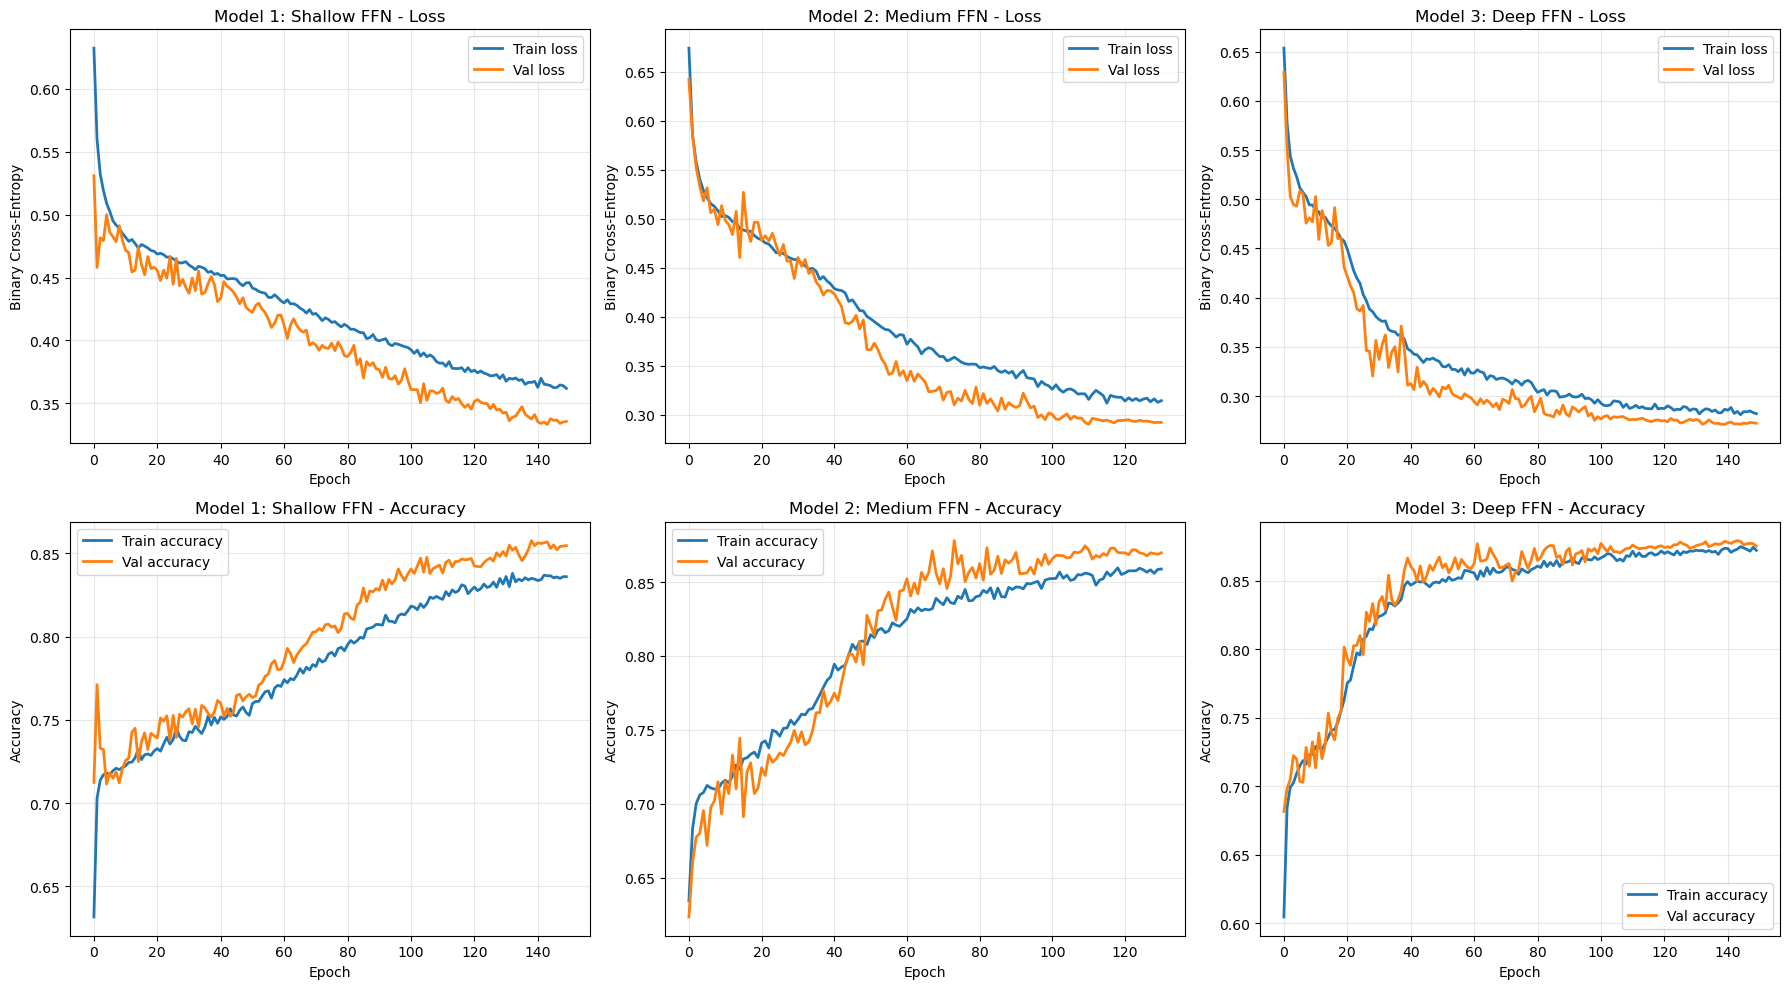

In [8]:
# Plot training curves for all 3 models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Model 1 plots
axes[0, 0].plot(history1.history['loss'], label='Train loss', linewidth=2)
axes[0, 0].plot(history1.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Cross-Entropy')
axes[0, 0].set_title('Model 1: Shallow FFN - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history1.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 0].plot(history1.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Model 1: Shallow FFN - Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model 2 plots
axes[0, 1].plot(history2.history['loss'], label='Train loss', linewidth=2)
axes[0, 1].plot(history2.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Binary Cross-Entropy')
axes[0, 1].set_title('Model 2: Medium FFN - Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history2.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 1].plot(history2.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Model 2: Medium FFN - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model 3 plots
axes[0, 2].plot(history3.history['loss'], label='Train loss', linewidth=2)
axes[0, 2].plot(history3.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Binary Cross-Entropy')
axes[0, 2].set_title('Model 3: Deep FFN - Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history3.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 2].plot(history3.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Model 3: Deep FFN - Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Model Evaluation & Comparison on Test Set


In [9]:
# Evaluate all 3 models on test set
print("="*80)
print("TEST SET EVALUATION - ALL 3 MODELS")
print("="*80)

results = {}

for i, (model, name) in enumerate([(model1, "Model 1: Shallow FFN"), 
                                    (model2, "Model 2: Medium FFN"), 
                                    (model3, "Model 3: Deep FFN")], 1):
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Get predictions
    probs = model.predict(X_test_np, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=3, target_names=['Non-pop', 'Pop']))
    
    # ROC AUC
    try:
        auc = roc_auc_score(y_test, probs)
        print(f"\nROC AUC: {auc:.4f}")
    except Exception as e:
        print(f"\nROC AUC: Could not compute - {e}")
        auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'probs': probs,
        'preds': preds,
        'cm': cm
    }
    
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Non-pop  Pop")
    print(f"Actual Non-pop  {cm[0,0]:5d}  {cm[0,1]:4d}")
    print(f"        Pop     {cm[1,0]:5d}  {cm[1,1]:4d}")

# Summary comparison
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC AUC':<10}")
print("-"*80)
for name, metrics in results.items():
    print(f"{name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
          f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['auc']:<10.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   ROC AUC: {results[best_model_name]['auc']:.4f}")


TEST SET EVALUATION - ALL 3 MODELS

Model 1: Shallow FFN

Classification Report:
              precision    recall  f1-score   support

     Non-pop      0.951     0.860     0.903      1677
         Pop      0.511     0.766     0.613       321

    accuracy                          0.845      1998
   macro avg      0.731     0.813     0.758      1998
weighted avg      0.880     0.845     0.856      1998


ROC AUC: 0.9214

Confusion Matrix:
                Predicted
              Non-pop  Pop
Actual Non-pop   1442   235
        Pop        75   246

Model 2: Medium FFN

Classification Report:
              precision    recall  f1-score   support

     Non-pop      0.959     0.869     0.912      1677
         Pop      0.541     0.807     0.647       321

    accuracy                          0.859      1998
   macro avg      0.750     0.838     0.780      1998
weighted avg      0.892     0.859     0.869      1998


ROC AUC: 0.9410

Confusion Matrix:
                Predicted
             

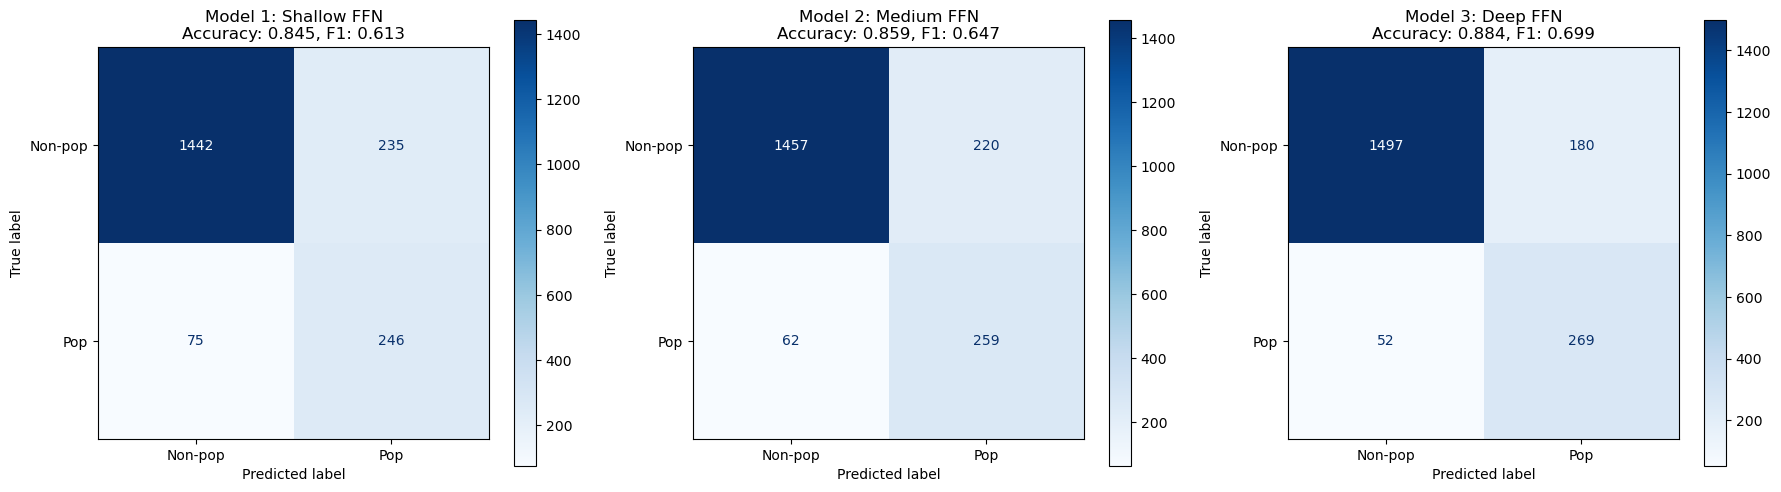

In [10]:
# Plot Confusion Matrices for all 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, metrics) in enumerate(results.items()):
    cm = metrics['cm']
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-pop', 'Pop'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.3f}, F1: {metrics["f1"]:.3f}')

plt.tight_layout()
plt.show()


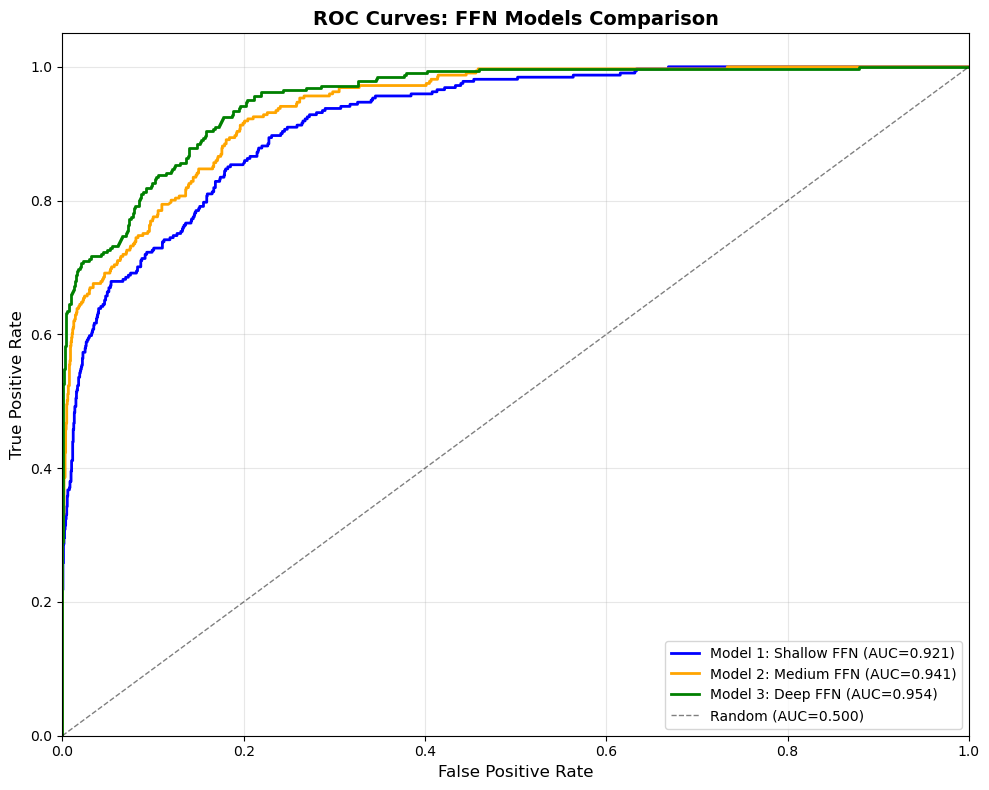

In [11]:
# Plot ROC Curves for all 3 models
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

colors = ['blue', 'orange', 'green']
for idx, (name, metrics) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC={metrics["auc"]:.3f})', 
             linewidth=2, color=colors[idx])

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: FFN Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


## 3. Improved Models


### Improved Keras FFNN


Class weights: {0: 0.5955926146515783, 1: 3.115264797507788}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,953 (23.25 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6145 - loss: 0.8055 - val_accuracy: 0.4898 - val_loss: 0.7897 - learning_rate: 0.0010
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 0.7153 - val_accuracy: 0.6037 - val_loss: 0.7031 - learning_rate: 0.0010
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6741 - loss: 0.6675 - val_accuracy: 0.6694 - val_loss: 0.6435 - learning_rate: 0.0010
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6920 - loss: 0.6406 - val_accuracy: 0.6892 - val_loss: 0.6052 - learning_rate: 0.0010
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.7025 - loss: 0.6210 - val_accuracy: 0.6929 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7057 - loss: 0.6015 - val_accuracy: 0.6884 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7072

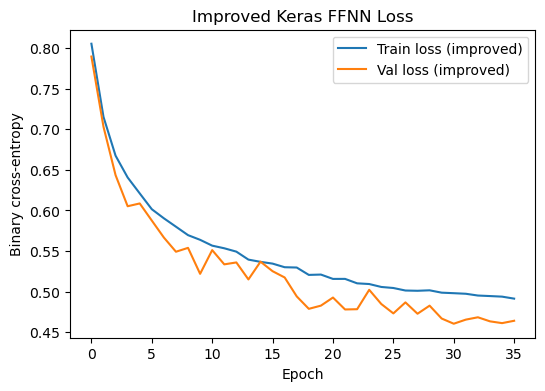

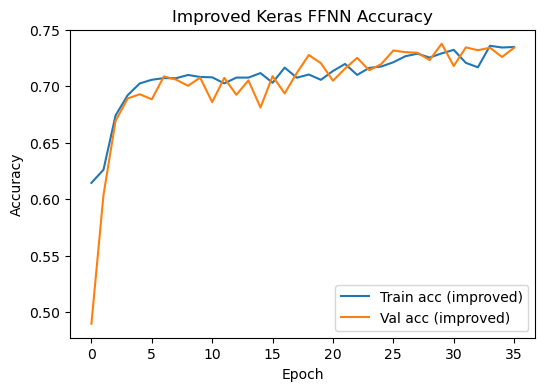

In [12]:
# Compute class weights for imbalanced labels
from sklearn.utils import class_weight

classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
print('Class weights:', class_weight_dict)

# Build improved FFNN with BatchNorm, Dropout, and L2 regularization
reg = tfk.regularizers.l2(1e-3)  # Stronger L2 regularization to prevent overfitting
input_dim = X_train_np.shape[1]

improved_model = tfk.Sequential([
    tfl.Input(shape=(input_dim,)),
    tfl.Dense(64, activation='relu', kernel_regularizer=reg),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),  # Increased dropout to prevent overfitting
    tfl.Dense(32, activation='relu', kernel_regularizer=reg),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),  # Increased dropout to prevent overfitting
    tfl.Dense(16, activation='relu', kernel_regularizer=reg),
    tfl.Dense(1, activation='sigmoid'),
])

improved_model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[tfk.metrics.BinaryAccuracy(name='accuracy')]
)

improved_model.summary()

callbacks_improved = [
    tfkc.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # More aggressive early stopping
    tfkc.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
]

history_improved = improved_model.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=callbacks_improved,
    class_weight=class_weight_dict,
)

# Plot loss and accuracy for the improved model
plt.figure(figsize=(6,4))
plt.plot(history_improved.history['loss'], label='Train loss (improved)')
plt.plot(history_improved.history['val_loss'], label='Val loss (improved)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.title('Improved Keras FFNN Loss')
plt.legend()
plt.show()

if 'accuracy' in history_improved.history:
    plt.figure(figsize=(6,4))
    plt.plot(history_improved.history['accuracy'], label='Train acc (improved)')
    plt.plot(history_improved.history.get('val_accuracy', []), label='Val acc (improved)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Improved Keras FFNN Accuracy')
    plt.legend()
    plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
Best threshold (by F1 for pop class): 0.65
Precision: 0.606, Recall: 0.508, F1: 0.553


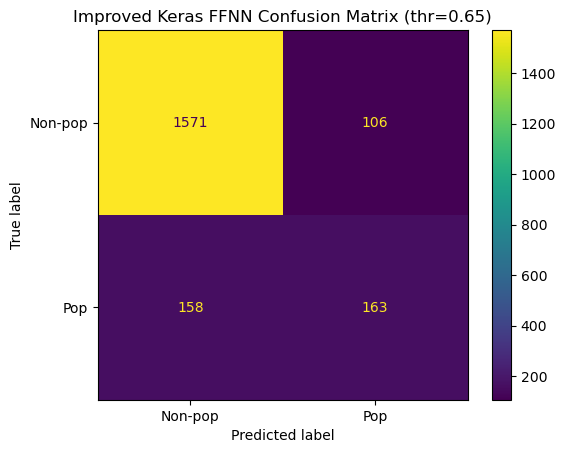

In [13]:
# Threshold tuning for improved model (optimize F1 for pop class)
from sklearn.metrics import precision_recall_fscore_support

probs_imp = improved_model.predict(X_test_np).ravel()

best_thresh = 0.5
best_f1 = -1.0
best_stats = None
thresholds = np.linspace(0.1, 0.9, 17)

for thr in thresholds:
    preds_thr = (probs_imp >= thr).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds_thr, average='binary', zero_division=0
    )
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thr
        best_stats = (precision, recall, f1)

print(f'Best threshold (by F1 for pop class): {best_thresh:.2f}')
print(f'Precision: {best_stats[0]:.3f}, Recall: {best_stats[1]:.3f}, F1: {best_stats[2]:.3f}')

# Confusion matrix at best threshold
best_preds = (probs_imp >= best_thresh).astype(int)
cm_imp = confusion_matrix(y_test, best_preds)
ConfusionMatrixDisplay(cm_imp, display_labels=['Non-pop', 'Pop']).plot()
plt.title(f'Improved Keras FFNN Confusion Matrix (thr={best_thresh:.2f})')
plt.show()
